<div class="alert alert-block alert-info">   

# Energy usage forcasting Project for YVR airport
This project is guided by Martha Essak  

</div>

### Group member:


<br>
Ken Yung <br>
Kristy Yu
</code> 

---

## Table of Contents
[Project description](#Description)  
[Part A: Time plot, trying transformations/adjustments, creating training and test set](#PartA)  
[Part B](#PartB)  
[Introduction & Approach](#Introduction)  
[Exploratory Data Analysis](#EDA1)  
[Potential causes of patterns](#Causes)   
[Exponential Smoothing Model](#ETS)  
[ARIMA model](#ARIMA)  
[Comparison of models](#Compare)  
[Forecasts](#Forecast)  
[Discussion](#Discussion)  
[Explanatory model](#Explanatory)


[Appendix A: ETS Models](#AppendixA)  
[Appendix B: ARIMA Models](#AppendixB)

---

<div class="alert alert-block alert-info">   
<a id="Description"></a>

# Project description

**Objective**  

The main goal of this project is to develop a model to forecast monthly energy use for the Vancouver International Airport (YVR).  

<br>

**Introduction**  

Budget planning at YVR requires forecasting the cost of energy to operate the airport. An accurate forecast could help the YVR representatives negotiate more favourable contracts with energy suppliers.

<br>

**Data Available**  

Data was taken from 14 years of records from the YVR database. This data set includes information on date, energy use, temperature, terminal area, and number of passengers. Data have been aggregated by month into 168 records (14 years with 12 months each).  

<br>


| # | Variable | Definition |  
| :- | :- | :- |  
| 1 | month | Month and year, e.g.: Nov-98 |
| 2 | energy | Energy use measured in thousands of kilowatt hours (kWh) |
| 3 | mean.temp | Mean monthly temperature outside (degrees Celsius) |
| 4 | total.area | Total area of all terminals (sq. m.) |
| 5 | total.passengers | Total number of passengers in thousands |
| 6 | domestic.passengers | Total number of domestic passengers (traveling within Canada) in thousands |
| 7 | US.passengers | Total number of passengers traveling between Canada and the US in thousands |
| 8 | international.passengers | Total number of passengers traveling between YVR and countries other than Canada/US |


In this project, you will develop appropriate models, compare the models, and discuss advantages and limitations of each model. You should select the best model and use it to provide monthly forecasts for energy use for the next three years (January 2011 through December 2013).   
    </div>

---

<div class="alert alert-block alert-info">   

# Part A 
## Time plot, trying transformations/adjustments, creating training and test set
### See Canvas submission called "Project: Part A" for detailed questions and points breakdown.
<a id="PartA"></a>  

</div>

In [1]:
library(fpp2)
library(repr)
library(seasonal)

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 

-- Attaching packages ---------------------------------------------- fpp2 2.4 --

v ggplot2   3.3.6     v fma       2.4  
v forecast  8.19      v expsmooth 2.3  






### Import the data

In [2]:
#load the csv data and check top 6 rows
mydata = read.csv('Energy use at YVR.csv')
head(mydata)

month  energy mean.temp total.area total.passengers domestic.passengers
1 Jan-97 5958    3.9      202966     1068.36          573.84             
2 Feb-97 5859    5.0      202966     1040.30          570.36             
3 Mar-97 5230    6.3      202966     1195.47          632.68             
4 Apr-97 5654    9.1      202966     1086.42          599.11             
5 May-97 5618   14.0      202966     1244.52          673.70             
6 Jun-97 5963   15.6      202966     1352.89          729.84             
  US.passengers international.passengers
1 263.13        231.38                  
2 267.39        202.56                  
3 319.09        243.71                  
4 265.37        221.94                  
5 307.55        263.27                  
6 333.89        289.16

In [3]:
temp.ts <- ts(mydata$mean.temp, frequency=c(12), start=c(1997))
area.ts <- ts(mydata$total.area, frequency=c(12), start=c(1997))
passenger.ts <- ts(mydata$total.passengers, frequency=c(12), start=c(1997))
domestic.ts <- ts(mydata$domestic.passengers, frequency=c(12), start=c(1997))
US.ts <- ts(mydata$US.passengers, frequency=c(12), start=c(1997))
international.ts <- ts(mydata$international.passengers, frequency=c(12), start=c(1997))


### Time plot

In [4]:
#convert the data to a time series object
energy.ts <- ts(mydata$energy, frequency=c(12), start=c(1997))

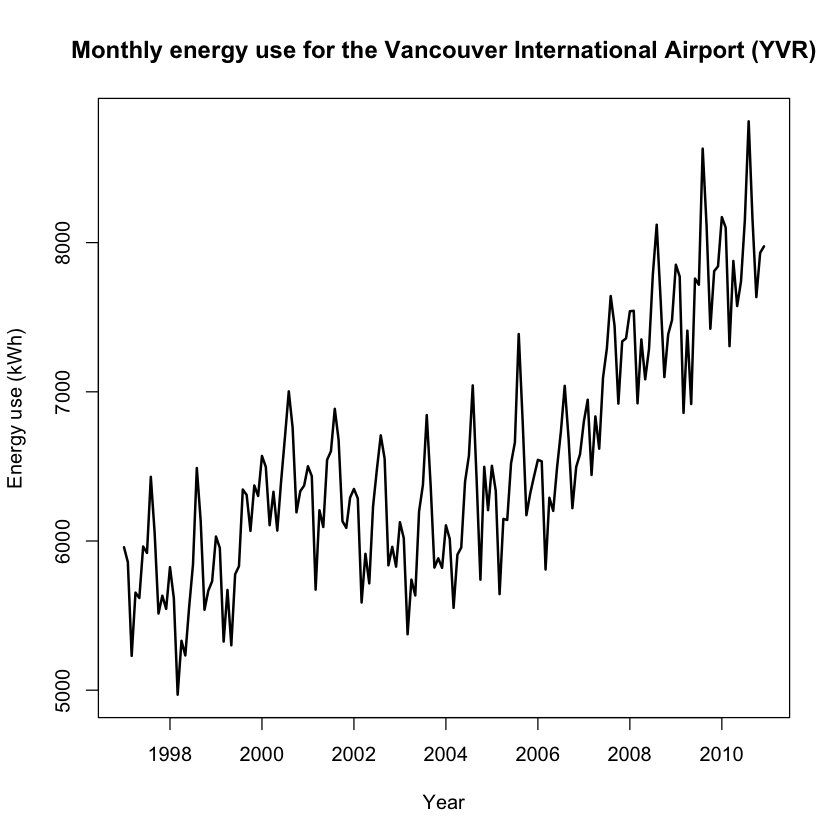

In [5]:
plot(energy.ts, ylab="Energy use (kWh)", xlab="Year", main="Monthly energy use for the Vancouver International Airport (YVR)", lwd=2)


### Box-Cox transformation

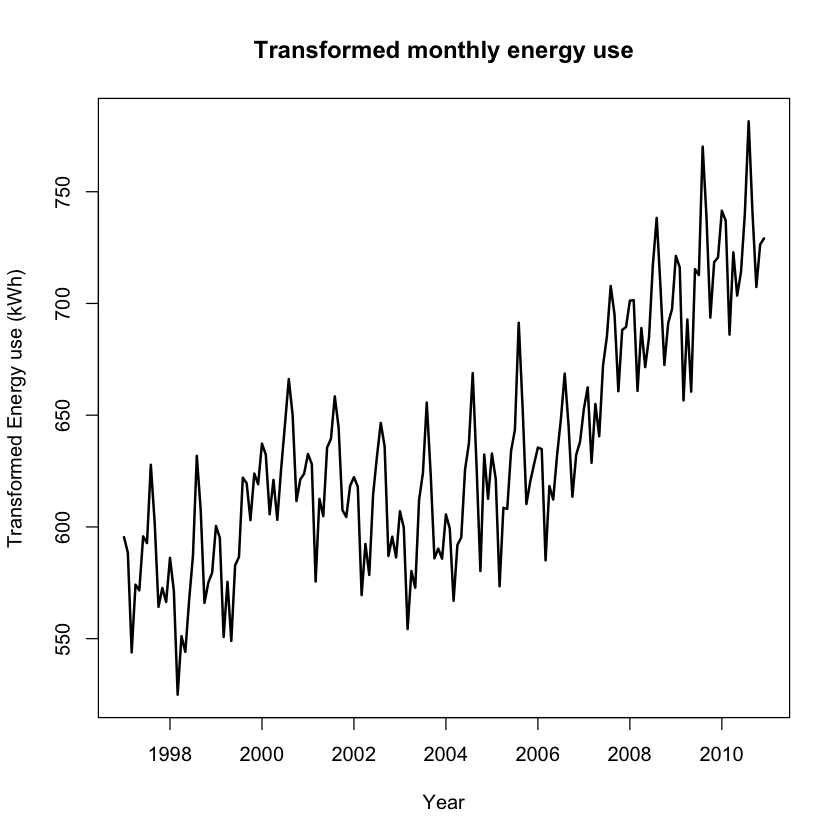

In [6]:
#apply box-cox on energy data
lambda = BoxCox.lambda(energy.ts) 

#allow R to select the "best" value for lambda to make variance equal

plot(BoxCox(energy.ts,lambda), ylab="Transformed Energy use (kWh)",
    xlab="Year", main="Transformed monthly energy use", lwd=2)

The purpose of the Box-Cox transformation is to find the closest parameter lambda such that seasonal variation of the data become more equal (convert multiplicative seasonal components to additive). Since the seasonal variation in the original data set is quite consistent over time (additive), using the Box-Cox transformation is not effective for this dataset.


### Calendar adjustment for number of days in each month

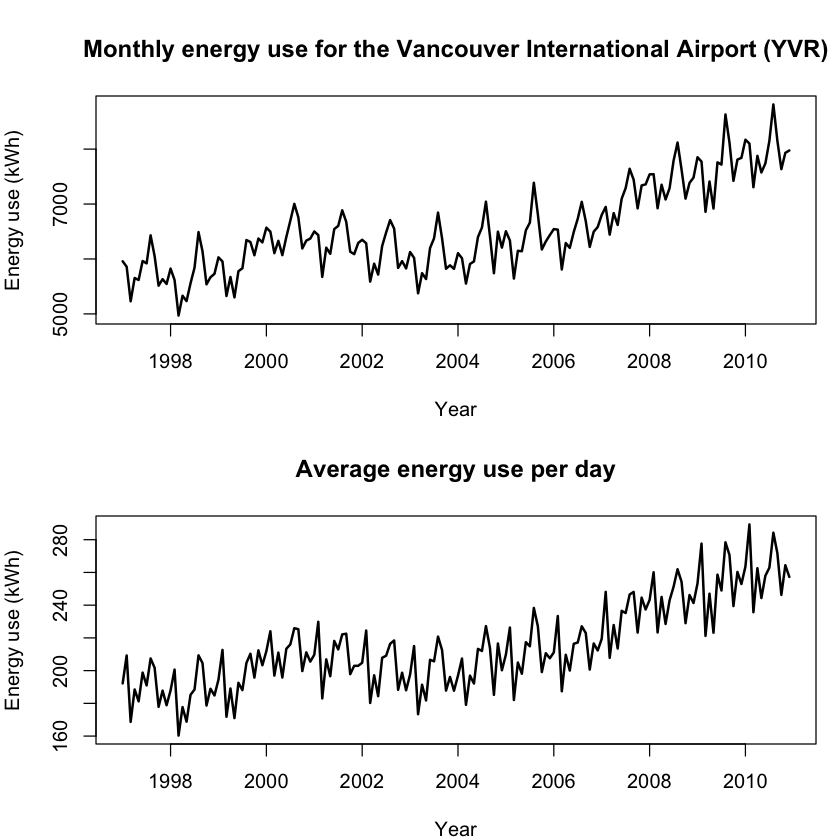

In [7]:
par(mfrow=c(2,1), mar=c(4,4,4,1))
plot(energy.ts, ylab="Energy use (kWh)", xlab="Year", main="Monthly energy use for the Vancouver International Airport (YVR)", lwd=2)
plot(energy.ts/monthdays(energy.ts), main="Average energy use per day", ylab="Energy use (kWh)", xlab="Year", lwd=2)

The purpose of using calendar adjustment is to reduce the variation of different number of days in each month. Calendar adjustment is not effective for this dataset because the calendar effect is not the main factor for the variation in the data. And the line plot has not become smoother after adjustments.

### Divide the data into the training set and the test set

In [8]:
#test set should be 3 years
energy.ts.train <- window(energy.ts, end=c(2007,12)) # 11 years
energy.ts.test <- window(energy.ts, start=c(2008,1)) # 3 years

----

<div class="alert alert-block alert-info">   

# Part B
### Note that Part B includes everything below this header
<a id="PartB"></a>  

</div>

<div class="alert alert-block alert-success">
<a id="Introduction"></a>  

# Introduction & Approach
</div>

This analysis aims to identify a model to forecast monthly energy use for the YVR airport, while complying with all model assumptions. Energy is a major component in airport operation costs. The ability to forecast usage can reduce uncertainty on energy production and transmission. Therefore, it can be used to negotiate a better contract with energy suppliers to save costs.  

Before making a model, we first visualize the data and determine if any transformation is needed. Then we divide the data into a training and a testing set. There are 3 methods forecast the energy use. First, we attempt 4 basic models: mean, naive, drift and seasonal naive method. We calculate the accuracy measures for the test set data and select the best basic model. The second method is the ETS model with different notations and identify the one with the best accuracy measures. 

The third approach is the ARIMA model. First, we will plot the ACF and PACF to determine what types of differencing should be applied to make the data stationary. Afterwards, different orders of autoregressive and moving average parts are tried for both non-seasonal and seasonal components. Accuracy measures and AICc are used to identify the best model.

For ETS and ARIMA models, we also perform residual analysis to ensure it has a normal distribution with mean of 0. Finally, comparing the best models from the three methods, a final model would be selected.


----

<div class="alert alert-block alert-warning">
<a id="EDA1"></a>

# Exploratory Data Analysis 

<br> 

Seasonality: The seasonality is one year. There is one peak in August every year. There is one valley in March every year, and the energy use in May and October are also low. The seasonal variation does not change over time.

Trend/cycle: There is an overall increasing trend. But there is a slight decrease of the trend from 2002 to 2004.

Unusual features: Although there is an increasing trend, there is a slight decrease from 2002 to 2004. The exact reason disrupting the trend needs further investigations.
</div>

In [9]:
# perform STL decomposition with default t.window
elec_stl = stl(energy.ts, s.window="periodic", robust=TRUE) # periodic means that the seasonality is not allowed to change over time. 
plot(elec_stl, main = 'STL decomposition of energy use data for YVR airport')

In [10]:
ggseasonplot(energy.ts, year.labels=TRUE, year.labels.left=TRUE) + 
      ggtitle("Seasonal plot: Monthly energy use for YVR") +
      ylab("Energy Use(kWh)")

<div class="alert alert-block alert-warning">
<a id="Causes"></a>

# Potential causes
 
</div>

The patterns in electricity use at YVR airport can be attributed to two main factors. \
\
Firstly, the seasonality pattern seen in electricity usage appears to be closely correlated with the number of passengers in the terminal as well as the mean temperature outside. This suggests that electricity usage is likely driven by factors such as heating, cooling, and lighting requirements within the terminal, which fluctuate based on the number of passengers and the temperature outside. For example, during peak travel season, when the number of passengers in the terminal is high, the heating, cooling and lighting requirements are likely to be greater, leading to increased electricity usage. Conversely, during low travel season, when the number of passengers is low and temperatures are mild, electricity usage is likely to be lower.\
\
Secondly, the trend pattern in electricity use appears to be aligned with the change in the total area of the terminal. This indicates that as the terminal expands, the electricity usage increases as well, possibly due to an increase in lighting, cooling, and heating systems required to support the larger space. For instance, as the total area of the terminal increases, so does the amount of lighting required to adequately illuminate the space, leading to an increase in electricity usage.


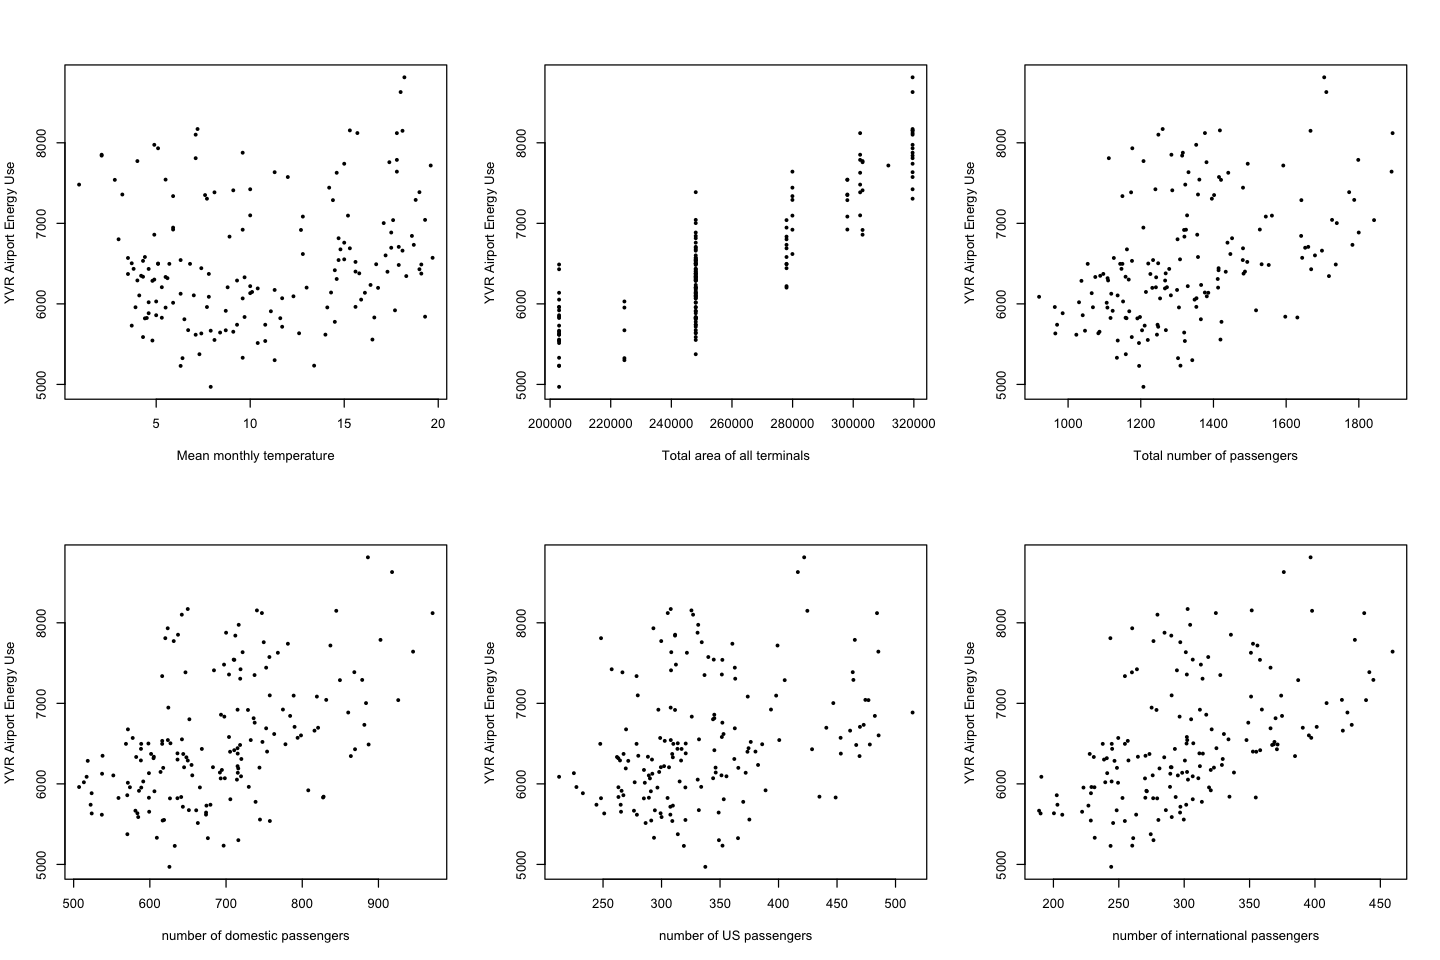

In [11]:
options(repr.plot.width=12, repr.plot.height=8)
par(mfrow=c(2,3))
plot(energy.ts ~ temp.ts,pch = 16, ylab ='YVR Airport Energy Use',xlab = 'Mean monthly temperature')
plot(energy.ts ~ area.ts, pch = 16,ylab='YVR Airport Energy Use', xlab ='Total area of all terminals')
plot(energy.ts ~ passenger.ts, pch = 16, ylab = 'YVR Airport Energy Use',xlab = "Total number of passengers")
plot(energy.ts ~ domestic.ts, pch = 16,ylab='YVR Airport Energy Use', xlab ='number of domestic passengers')
plot(energy.ts ~ US.ts, pch = 16,ylab='YVR Airport Energy Use', xlab ='number of US passengers')
plot(energy.ts ~ international.ts, pch = 16,ylab='YVR Airport Energy Use', xlab ='number of international passengers')


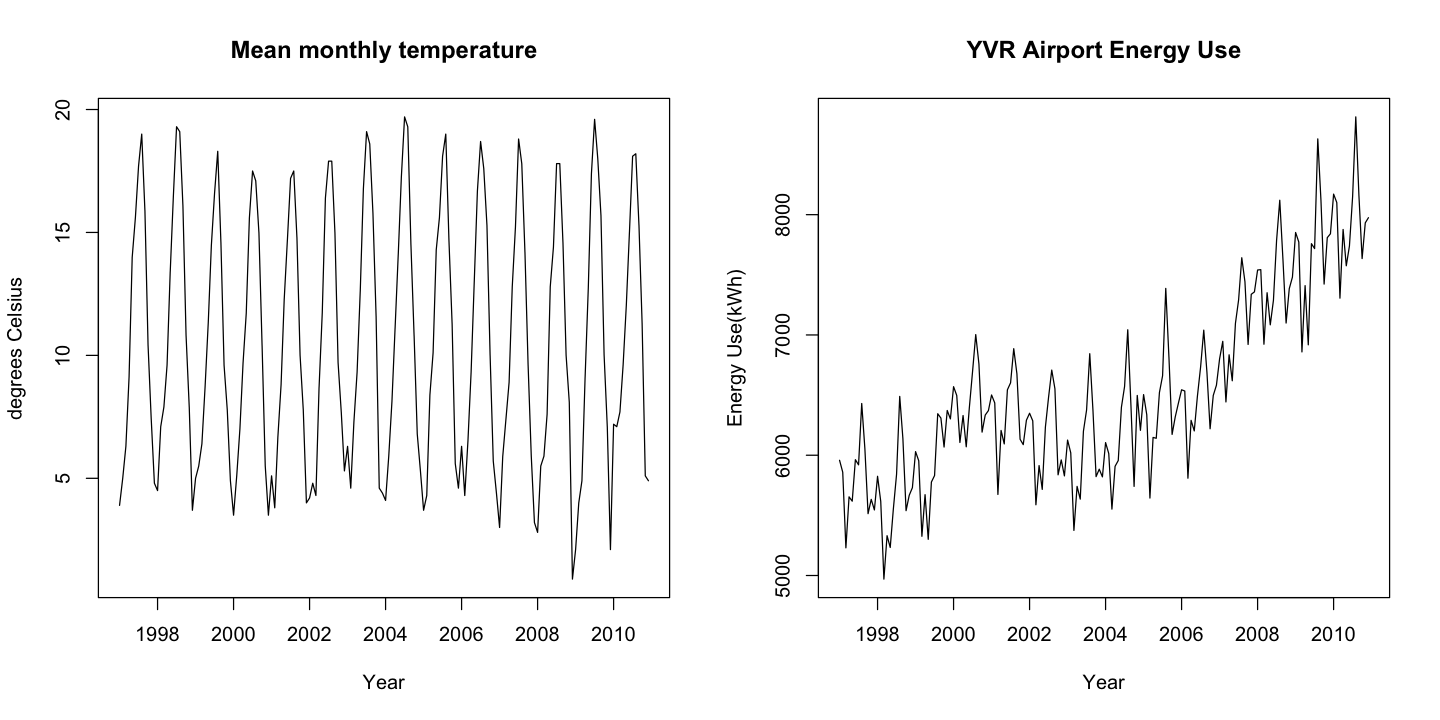

In [12]:
options(repr.plot.width=12, repr.plot.height=6)
par(mfrow=c(1,2))
plot(temp.ts, main="Mean monthly temperature", ylab = "degrees Celsius", xlab = "Year")
plot(energy.ts, main="YVR Airport Energy Use", ylab = "Energy Use(kWh)", xlab = "Year")

In [13]:
options(repr.plot.width=12, repr.plot.height=6)
par(mfrow=c(1,2))
plot(passenger.ts, main="Total number of passengers", ylab = "Thousands", xlab = "Year")
plot(energy.ts, main="YVR Airport Energy Use", ylab = "Energy Use (kWh)", xlab = "Year")

In [14]:
options(repr.plot.width=12, repr.plot.height=6)
par(mfrow=c(1,2))
plot(area.ts, main="Total area of all terminals", ylab = "sq. m.", xlab = "Year")
plot(energy.ts, main="YVR Airport Energy Use", ylab = "Energy Use (kWh)", xlab = "Year")

----

<div class="alert alert-block alert-success">
<a id="Basic"></a>

# Basic forecasting methods
</div>  

 
## Visual comparison and assessment of basic methods 



In [15]:
#mean method
basic.mean <- meanf(energy.ts.train, h=36)
#drift method
basic.drift <- rwf(energy.ts.train, drift=TRUE, h=36)
#navie method
basic.navie <- naive(energy.ts.train, h=36)
#seasonal navie method
basic.snavie <- snaive(energy.ts.train, h=36)


In [16]:
method <- c("Mean method","Drift method","Naive method","Seasonal naive method")
plot(energy.ts, main="Forecasts for YVR Airport Energy Use", ylab = "Energy Use(kWh)", xlab = "Year")
lines(basic.mean$mean,col='blue')
lines(basic.drift$mean,col='green')
lines(basic.navie$mean,col='red')
lines(basic.snavie$mean,col='purple')
legend("topleft",lty=1,col=c('blue','green','red','purple'), legend=method)

Based on the forcasts above, drift method generates the most accurate forcast as it captured the increasing trend of the energy use. However, it fails to capture the seasonality. Seasonal naive method captured the seasonal trend but not the increasing trend.

## Accuracy measures 
Create a table with the RMSE, MAE, MAPE, and MASE for the test set for each of the four basic methods. Round values to 1 decimal place.

In [17]:
cbind(method, round(rbind(
      accuracy(basic.mean, energy.ts.test)[2,c(2,3,5,6)],
      accuracy(basic.drift, energy.ts.test)[2,c(2,3,5,6)],
      accuracy(basic.navie, energy.ts.test)[2,c(2,3,5,6)],
      accuracy(basic.snavie, energy.ts.test)[2,c(2,3,5,6)]
      ),1))

method                RMSE   MAE    MAPE MASE
[1,] Mean method           1528.5 1463.8 18.8 5.5 
[2,] Drift method          416    328.5  4.2  1.2 
[3,] Naive method          550.1  443.2  5.6  1.7 
[4,] Seasonal naive method 698.7  626.8  8    2.4

## Comparison of basic methods 


Based on the accuracy measures, drift method is the best forecast for the test set given the lowest scale error (MASE). MASE is a scale-independent error which being scaled using the naïve forecast/seasonal naïve forecast, making the errors comparable across different models.

----

<div class="alert alert-block alert-success">
<a id="ETS"></a>

# Exponential Smoothing (ETS) model


    
</div>    

The ETS model that generated the best forecast is `ETS(M, A, A)`

In [18]:
ets.maa = ets(energy.ts.train, model = 'MAA')

The smoothing parameter for level α is 0.8082.\
The smoothing parameter for trend β is 0.0001.\
The smoothing parameter for seasonality γ is 0.0001.

In [19]:
summary(ets.maa)

ETS(M,A,A) 

Call:
 ets(y = energy.ts.train, model = "MAA") 

  Smoothing parameters:
    alpha = 0.8082 
    beta  = 1e-04 
    gamma = 1e-04 

  Initial states:
    l = 5803.689 
    b = 17.436 
    s = -37.9185 -34.4259 -248.9098 320.0811 666.5463 231.972
           63.7197 -351.3296 -188.4109 -568.7838 53.8096 93.6498

  sigma:  0.0218

     AIC     AICc      BIC 
1957.628 1962.996 2006.636 

Training set error measures:
                    ME     RMSE     MAE        MPE     MAPE      MASE
Training set -6.611667 126.3696 99.4423 -0.1458104 1.602955 0.3752775
                    ACF1
Training set -0.02754951

From the time plot and the decomposition plot, we can observed that the data has seasonal pattern with one peak each year, occurring around Aug with equal variance, indicating that it has additive seasonality. Beside seasonality, the data has a linear increasing trend, indicating additive trend. With additive seasonality and additive trend, the variance of the residuals increases with the level of the series, indicating that the errors are multiplicative.

## Model plot 


In [20]:
plot(forecast(ets.maa, 36), main = 'Forecast of YVR Energy Used from ETS(M, A, A)',
                ylab = "Energy Use (kWh)", xlab = "Year")
lines(energy.ts.test)
lines(fitted(ets.maa), col="blue") 

## Goodness of fit


All three ETS methods show similar goodness of fit to the model with the training set. Indeed, ETS(A,A,A) has the lowest error with the training set.

In [21]:
ets.mmm = ets(energy.ts.train, model = 'MMM')
ets.aaa = ets(energy.ts.train, model = 'AAA')
ETS_method <- c('MAA', 'MMM','AAA')
cbind(ETS_method, round(rbind(
      accuracy(ets.maa)[,c(2,3,5,6)],
      accuracy(ets.mmm)[,c(2,3,5,6)],
      accuracy(ets.aaa)[,c(2,3,5,6)]
      ),3))

ETS_method RMSE    MAE    MAPE  MASE 
[1,] MAA        126.37  99.442 1.603 0.375
[2,] MMM        128.308 99.26  1.585 0.375
[3,] AAA        126.261 98.958 1.594 0.373

## Accuracy measures


In [22]:
method <- c('ETS(M,A,A)','ETS(A,A,A)', 'Drift Method')
cbind(method, round(rbind(
    accuracy(forecast(ets.maa), energy.ts.test)[2,c(2,3,5,6)],
    accuracy(forecast(ets.aaa), energy.ts.test)[2,c(2,3,5,6)],
    accuracy(basic.drift, energy.ts.test)[2,c(2,3,5,6)]
),3))

method       RMSE    MAE     MAPE  MASE 
[1,] ETS(M,A,A)   159.108 126.276 1.695 0.477
[2,] ETS(A,A,A)   158.428 130.92  1.725 0.494
[3,] Drift Method 415.979 328.482 4.213 1.24

## Accuracy of forecasts 


Although ETS(A,A,A) model has the best goodness of fit on the training set, its mean of residuals indicating that the model has bias and the forecast on the test set did not perform well compared to the ETS(M,A,A) model. The ETS(M,A,A) model has the most accurate forecast on the test set data among all the ETS models and basic models, with the lowest MASE. And from the plot `Forecast of YVR Energy Used from ETS(M, A, A)`, we can observe that the forecast is the closest to the actual energy usage.

## Residual diagnostics 
 

a) The mean of the residuals is close to 0, indicating no bias.\
\
b) The time plot of the residuals indicates that there is not trend and variance is constant. The ACF plot of the residuals indicates that there is no significant autocorrelation. Residuals are approximately normally distributed.\
\
c) portmanteau test for autocorrelations:


H0: the first 24 autocorrelations are not significantly different from a white noise process.\
HA: the first 6 autocorrelations are significantly different from a white noise process.\
\
The test statistic is 12.469.\
\
The p-value is 0.1315.\
\
Using alpha = 0.05, we fail to reject H0, there is no significant autocorrelations for the first 24 lags of the residuals.


[1] -0.001043112


	Ljung-Box test

data:  Residuals from ETS(M,A,A)
Q* = 12.469, df = 8, p-value = 0.1315

Model df: 16.   Total lags used: 24



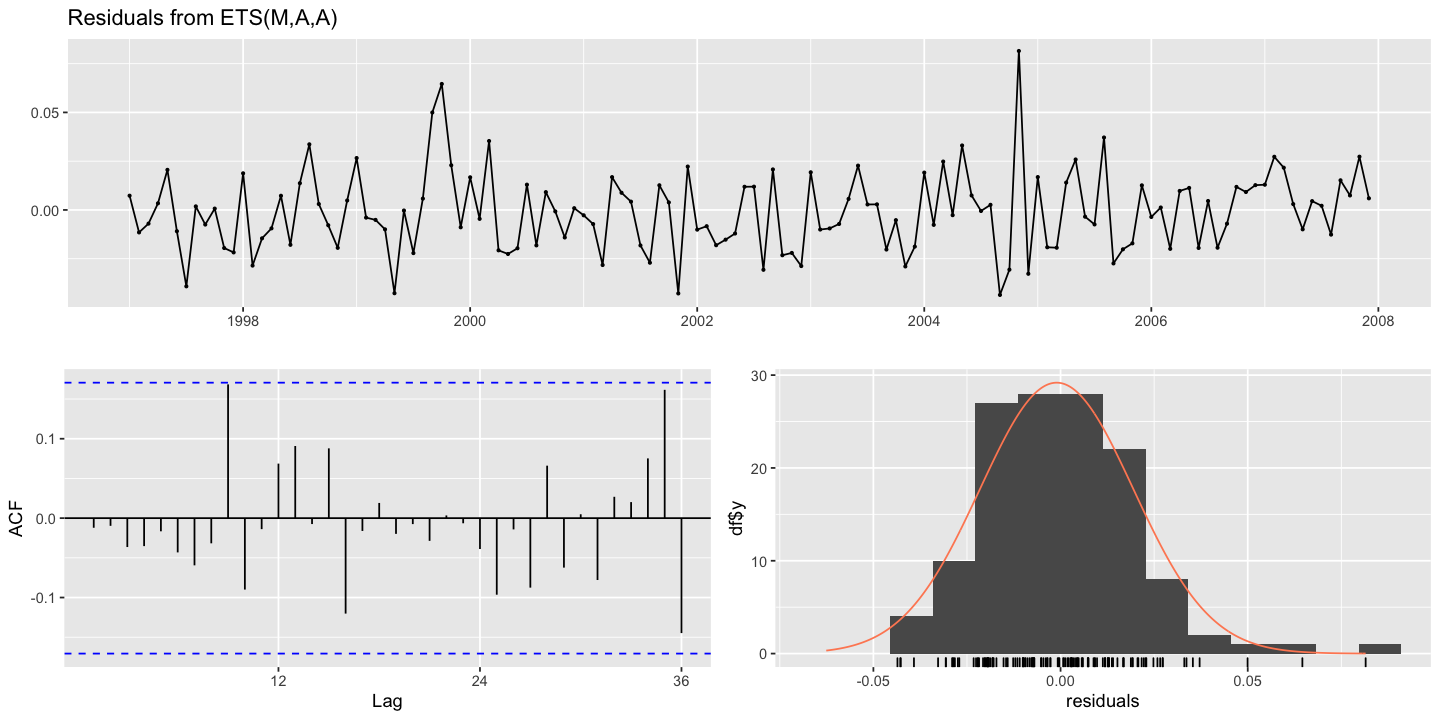

In [23]:
mean(residuals(ets.maa))
checkresiduals(ets.maa)

----

<div class="alert alert-block alert-success">
<a id="ARIMA"></a>
    
# ARIMA model
    

    
</div>    

The model is `ARIMA(1,1,0)x(2,1,1)12`.

In [24]:
fit.energy.3 <- Arima(energy.ts.train, order=c(1, 1, 0), seasonal=c(2, 1, 1)) 

The estimates of the parameters are -0.2126 for autoregressive coefficient, 0.1602 for seasonal autoregressive coefficient 1, 0.0107 for seasonal autoregressive coefficient 2 and -1 for seasonal moving average coefficient.


## Appropriateness of model


In [25]:
#first order differencing on top of seasonal
options(repr.plot.width=18, repr.plot.height=5)
par(mfrow=c(1,3))

plot(diff(diff(energy.ts.train,12)))
Acf(diff(diff(energy.ts.train,12)),48)
Pacf(diff(diff(energy.ts.train,12)),48)

The plot of differenced data shows no trend and seasonality and looks like white noise. <br>
Since both seasonal differencing and first order differencing are used to make the data stationary, d and D are 1. <br>
For the seasonal component, the PACF is simpler with less significant seasonal lag so P is 2 (lag 12 and 24). Since first seasonal lag of ACF is also significant, it is included as Q. <br>
For the non-seasonal component, the PACF is simpler with the first lag being significant so p is 1.

## Model plot


In [26]:
options(repr.plot.width=12, repr.plot.height=8)
plot(forecast(fit.energy.3,h=36), flwd=3, ylab="Energy used (kWh)", xlab="Year", main="3 year forecasts on the energy use for the Vancouver International Airport (YVR)")
lines(energy.ts.test)
lines(fitted(fit.energy.3), col="blue") 
legend("topleft",lty=1,lwd=2, col=c("black","royalblue2","blue"), c("Train and test data","ARIMA Forecasts","fitted value"))


## Goodness of fit



The goodness of fit indicator RMSE, MAE and MASE on training set for ARIMA (1,1,0)x(2,1,1)12 are lower than those of ARIMA(1,1,0)x(2,1,0)12. Therefore, `ARIMA (1,1,0)x(2,1,1)12` is preferred.

In [27]:
fit.energy.1 <- Arima(energy.ts.train, order=c(1, 1, 0), seasonal=c(2, 1, 0), include.constant=TRUE)
goodness_of_fit_train <- c('ARIMA (1,1,0)x(2,1,1)12', 'ARIMA(1,1,0)x(2,1,0)12')
cbind(goodness_of_fit_train, round(rbind(
      accuracy(forecast(fit.energy.3, h=36))[,c(2,3,5,6)],
      accuracy(forecast(fit.energy.1, h=36))[,c(2,3,5,6)]
      ),3))


goodness_of_fit_train   RMSE    MAE     MAPE  MASE 
[1,] ARIMA (1,1,0)x(2,1,1)12 124.164 90.223  1.437 0.34 
[2,] ARIMA(1,1,0)x(2,1,0)12  146.223 104.946 1.668 0.396

## Accuracy measures


In [28]:
#compare the accuracy measure
accuracy_measures_test <- c('ARIMA (1,1,0)x(2,1,1)12', 'ARIMA(1,1,0)x(2,1,0)12','drift method')
cbind(accuracy_measures_test, round(rbind(
      accuracy(forecast(fit.energy.3, h=36), energy.ts.test)[2,c(2,3,5,6)],
      accuracy(forecast(fit.energy.1, h=36), energy.ts.test)[2,c(2,3,5,6)],
      accuracy(basic.drift, energy.ts.test)[2,c(2,3,5,6)]
      ),3))


accuracy_measures_test  RMSE    MAE     MAPE  MASE 
[1,] ARIMA (1,1,0)x(2,1,1)12 172.833 125.743 1.666 0.475
[2,] ARIMA(1,1,0)x(2,1,0)12  532.031 459.577 5.986 1.734
[3,] drift method            415.979 328.482 4.213 1.24

## Accuracy of forecasts 

The ARIMA (1,1,0)x(2,1,1)12 model has lower RMSE, MAE, MAPE and MASE on the test set than the other models. <br> 
Also, from the plot below, the forecast of chosen model is closer to the test set than the base model. <br>

In [29]:
#generate forecasts for model 1 and 3 and adding the mean of residuals to all forecasts
fit.energy.1.forecasts <- forecast(fit.energy.1, h=36)$mean 
fit.energy.3.forecasts <- forecast(fit.energy.3, h=36)$mean 

#plot the forecasts with full data
options(repr.plot.width=12, repr.plot.height=8)
plot(energy.ts, ylim = c(4900,9200),lwd=2, ylab="Energy Use (kWh)", xlab="Year", main="Comparison of forecasts on the energy use for the Vancouver International Airport (YVR)")
lines(fit.energy.1.forecasts, col="blue", lwd=2)
lines(fit.energy.3.forecasts, col="forestgreen", lwd=3)
legend("topleft",lty=1,lwd=2, col=c("black","blue", 'forestgreen'), c("Train and test data","Base model: ARIMA(1,1,0)x(2,1,0)12","Chosen model: ARIMA (1,1,0)x(2,1,1)12"))

## Residual diagnostics 

a) The mean of the residuals is 9.58, indicating there are some levels of bias. The mean is added to all forecasts.\
\
b) The time plot of the residuals indicates that there is not trend and variance is constant. The ACF plot of the residuals indicates that there is 1 significant autocorrelation as there could be 5% significant autocorrelation due to chance. Residuals are approximately normally distributed with one outlier.\
\
c) portmanteau test for autocorrelations:\
\
H0: the first 24 autocorrelations are not significantly different from a white noise process.\
HA: the first 6 autocorrelations are significantly different from a white noise process.\
\
The test statistic is 18.452.\
\
The p-value is 0.5576.\
\
Using alpha = 0.05, we fail to reject H0, there is no significant autocorrelations for the first 24 lags of the residuals.


[1] 9.581445


	Ljung-Box test

data:  Residuals from ARIMA(1,1,0)(2,1,1)[12]
Q* = 18.452, df = 20, p-value = 0.5577

Model df: 4.   Total lags used: 24



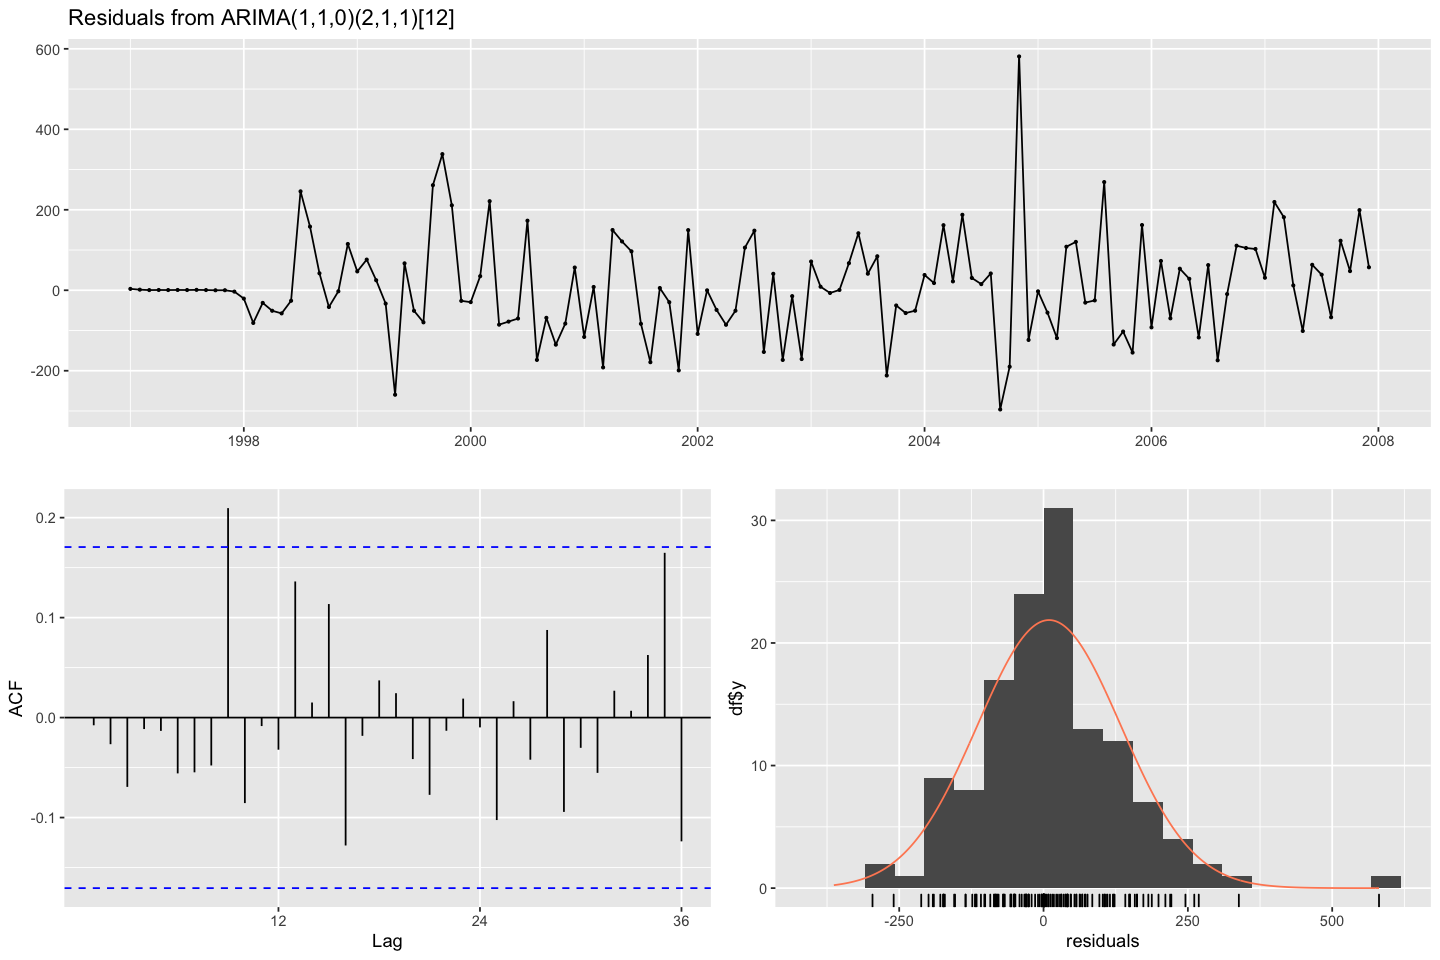

In [30]:
#check mean and residuals for model3
mean(residuals(fit.energy.3))

options(repr.plot.width=12, repr.plot.height=8)
checkresiduals(fit.energy.3)

----

<div class="alert alert-block alert-warning">
<a id="Comparison"></a>

# Comparison of models 
<div>


Based on the accuracy measure and the comparison plot, `ARIMA (1,1,0)x(2,1,1)12` and `ETS (M, A, A)` model show similar forecast result. `ARIMA (1,1,0)x(2,1,1)12` model seems to has better accuracy measure than `ETS (M, A, A)`(lower MAE, MAPE and MASE). However, the mean of residuals of the `ARIMA (1,1,0)x(2,1,1)12` model is not equal to 0, indicatin that the model has some levels of bias. In this case, `ETS (M, A, A)` model is the best forecasting method for the energy use of the YVR airport.

In [31]:
#compare the accuracy measure
accuracy_measures_test <- c('ARIMA (1,1,0)x(2,1,1)12', 'ETS (M, A, A)','drift method')
cbind(accuracy_measures_test, round(rbind(
      accuracy(forecast(fit.energy.3, h=36), energy.ts.test)[2,c(2,3,5,6)],
      accuracy(forecast(ets.maa), energy.ts.test)[2,c(2,3,5,6)],
      accuracy(basic.drift, energy.ts.test)[2,c(2,3,5,6)]
      ),3))


accuracy_measures_test  RMSE    MAE     MAPE  MASE 
[1,] ARIMA (1,1,0)x(2,1,1)12 172.833 125.743 1.666 0.475
[2,] ETS (M, A, A)           159.108 126.276 1.695 0.477
[3,] drift method            415.979 328.482 4.213 1.24

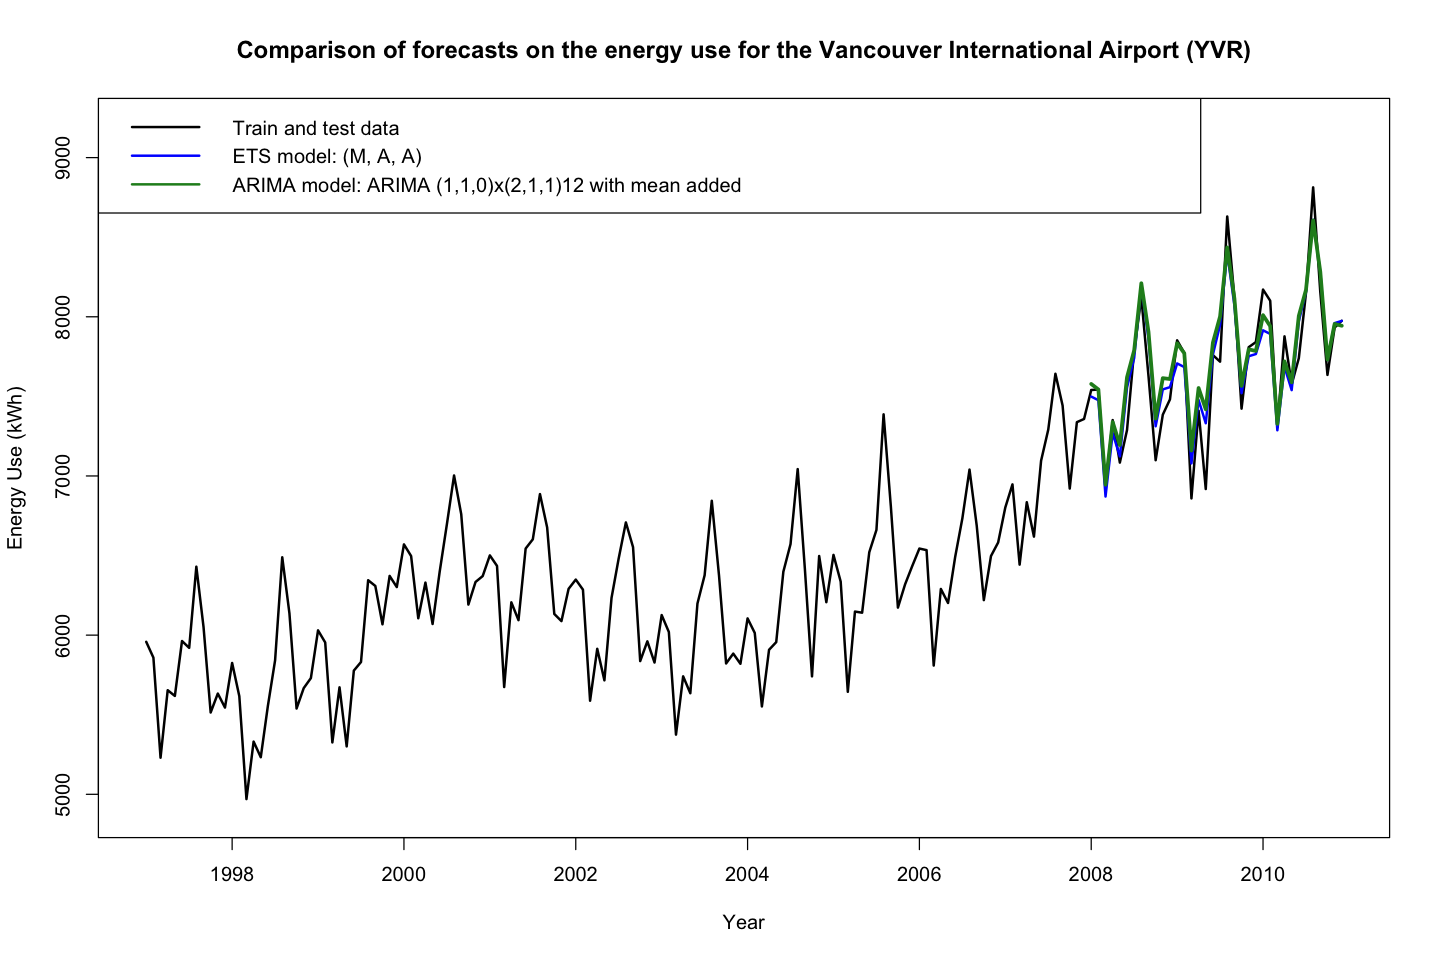

In [32]:
options(repr.plot.width=12, repr.plot.height=8)
plot(energy.ts, ylim = c(4900,9200),lwd=2, ylab="Energy Use (kWh)", xlab="Year", main="Comparison of forecasts on the energy use for the Vancouver International Airport (YVR)")
lines(forecast(ets.maa, 36)$mean, col="blue", lwd=2)
lines(fit.energy.3.forecasts, col="forestgreen", lwd=3)
legend("topleft",lty=1,lwd=2, col=c("black","blue", 'forestgreen'), c("Train and test data","ETS model: (M, A, A)","ARIMA model: ARIMA (1,1,0)x(2,1,1)12 with mean added"))

<div class="alert alert-block alert-info"> 
<a id="Forecasts"></a>   
    
# Forecasts 

</div>

In [33]:
options(repr.plot.width=15, repr.plot.height=8)
final_forcast = forecast(ets(energy.ts, model = ets.maa),36)
plot(final_forcast, main = 'Forecasts on the energy use for the Vancouver International Airport (YVR) for January 2011 to December 2013',
            ,ylab="Energy Use (kWh)", xlab="Year",xlim = c(1997,2014))



Model is being refit with current smoothing parameters but initial states are being re-estimated.
Set 'use.initial.values=TRUE' if you want to re-use existing initial values.



<div class="alert alert-block alert-warning">
<a id="Discussion"></a>

# Discussion 
<div>


The current model is based on additive trend and seasonality. Trend and seasonality could become multiplicative in the future, rendering the model unfit. For example, temperature affects energy use. Due to climate change, temperature may change drastically over time, leading to multiplicative seasonal trends. The model is unable to capture that.

In the future, if we need to change the model notation, ETS function can’t handle all variations. For example, notation “AMN” is forbidden by the function. There are certain ets models that are unstable. “AMN” is one of them. By unstable, it means that the models are better for short to medium term forecasts as long as the data are positive.

Also, ETS is accurate assuming there is a reasonable amount of continuity between the past and future. From the original data plot, there is a period from 2004-2006 with no trend (it is pretty flat). That is due to the no increase of terminal area. Once there is any expansion in the future. It breaks the continuity and we will see another sharp increase in energy use where ETS may not be able to handle.

ETS can't handle spikes/outliers in the original data since it is a smoothing line. These outliers may show up in the residual plot. We note there are some spikes in the residual plot around 2000 and 2005.

Our recommendation is to use ARIMA model for longer term (e.g. 10 years) forecasts. For short to medium term, ARIMA model can be the reference in case there is any change on seasonality and trend.


<div class="alert alert-block alert-success">
<a id="Explanatory"></a>

# Explanatory model
</div>

First, we need to identify variables that can explain the energy use. The temperature and number of passengers may explain the seasonality of the energy use, while the area of the terminal may explain the trend over years. We will include these 3 variables in a multivariate regression model by the way of forward selection. In each step of the forward selection, we will compare the adjusted R2 and AIC to see if the variable added helps improve the model accuracy. 

After having an explanatory model, we will perform forecasting for each variable. The process is the same as directly forecasting the energy use, either using ETS or ARIMA model. We will also check the residuals for each model.

With the explanatory model and new values of variables, we can predict the energy use in both ex-ante and ex-post. Comparing the results of the two, we can identify the source of forecast uncertainty, which could be due to the model itself or the forecasting of the predictors.


----

<div class="alert alert-block alert-danger">
<a id="AppendixA"></a>

# Appendix A:
# ETS models 
</div>

MAA

In [34]:
ets.maa = ets(energy.ts.train, model = 'MAA')
mean(residuals(ets.maa))
checkresiduals(ets.maa)

[1] -0.001043112


	Ljung-Box test

data:  Residuals from ETS(M,A,A)
Q* = 12.469, df = 8, p-value = 0.1315

Model df: 16.   Total lags used: 24



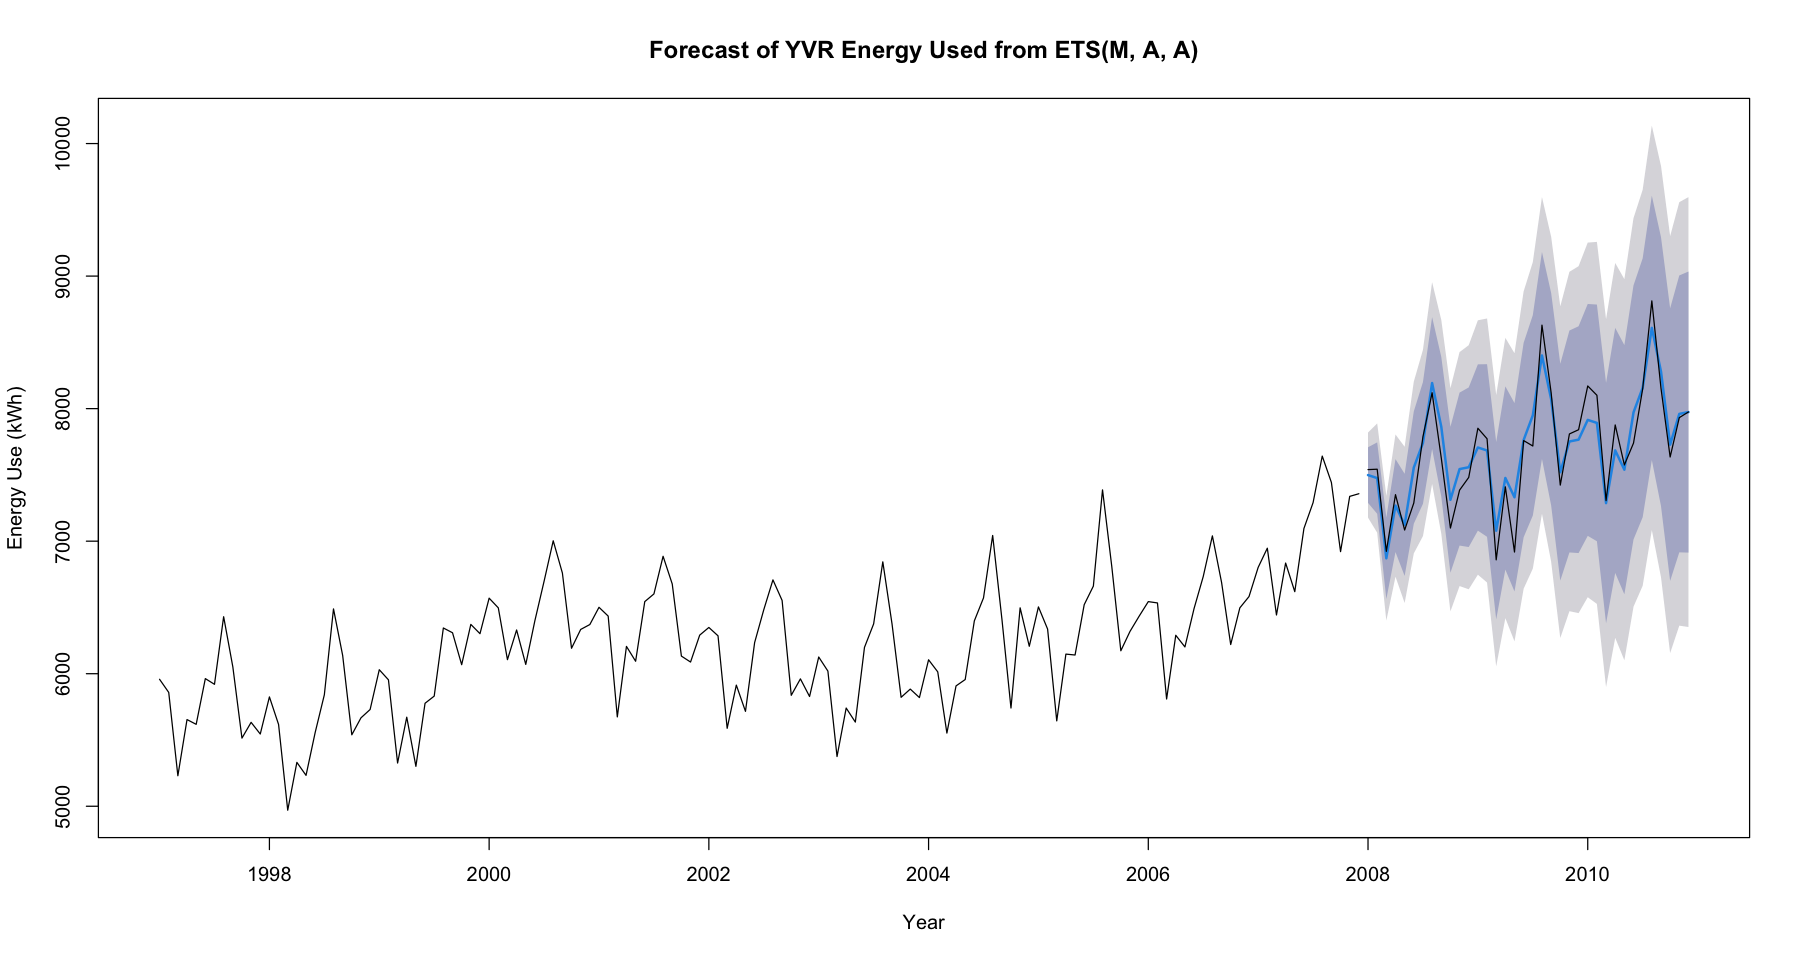

In [35]:
plot(forecast(ets.maa, 36), main = 'Forecast of YVR Energy Used from ETS(M, A, A)',
                ylab = "Energy Use (kWh)", xlab = "Year")
lines(energy.ts.test)

MMM

[1] 0.001578134


	Ljung-Box test

data:  Residuals from ETS(M,Md,M)
Q* = 15.271, df = 7, p-value = 0.03267

Model df: 17.   Total lags used: 24



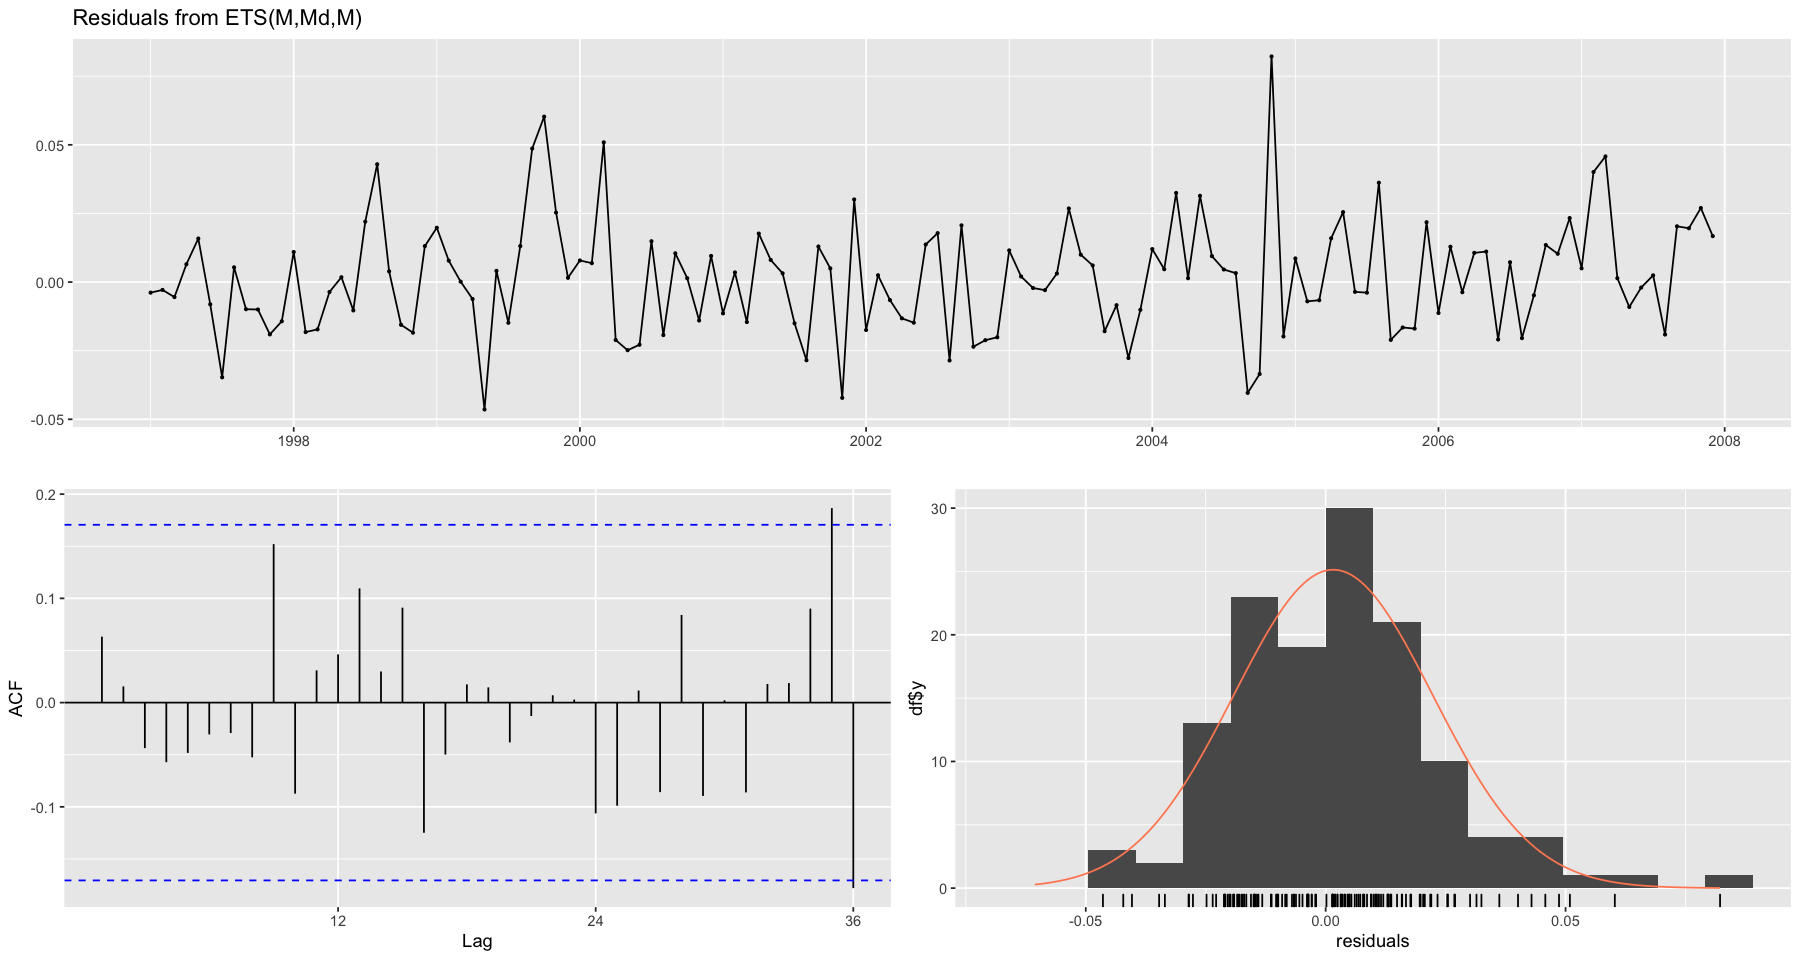

In [36]:
ets.mmm = ets(energy.ts.train, model = 'MMM')
mean(residuals(ets.mmm))
checkresiduals(ets.mmm)

In [37]:
plot(forecast(ets.mmm, 36), main = 'Forecast of YVR Energy Used from ETS(M, Md, M)',
                ylab = "Energy Use (kWh)", xlab = "Year")
lines(energy.ts.test)

MMdM

[1] 0.001578134


	Ljung-Box test

data:  Residuals from ETS(M,Md,M)
Q* = 15.271, df = 7, p-value = 0.03267

Model df: 17.   Total lags used: 24



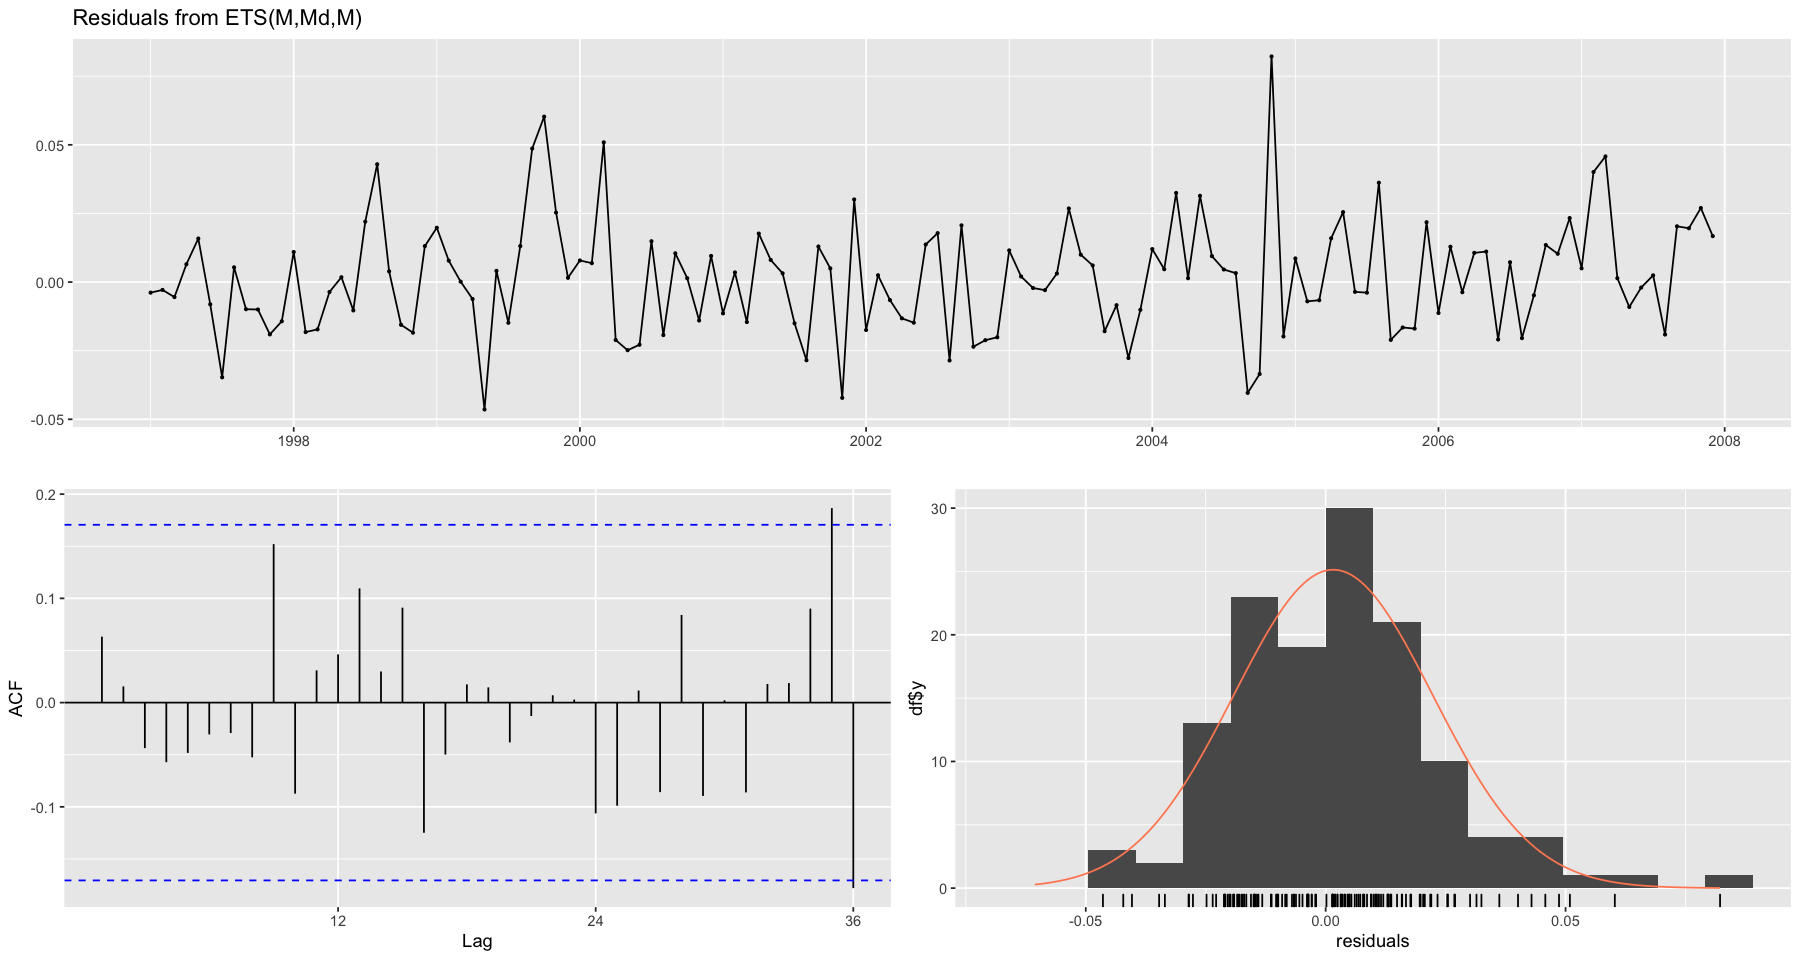

In [38]:
ets.mmdm = ets(energy.ts.train, model = 'MMM', damped=TRUE)
mean(residuals(ets.mmdm))
checkresiduals(ets.mmdm)

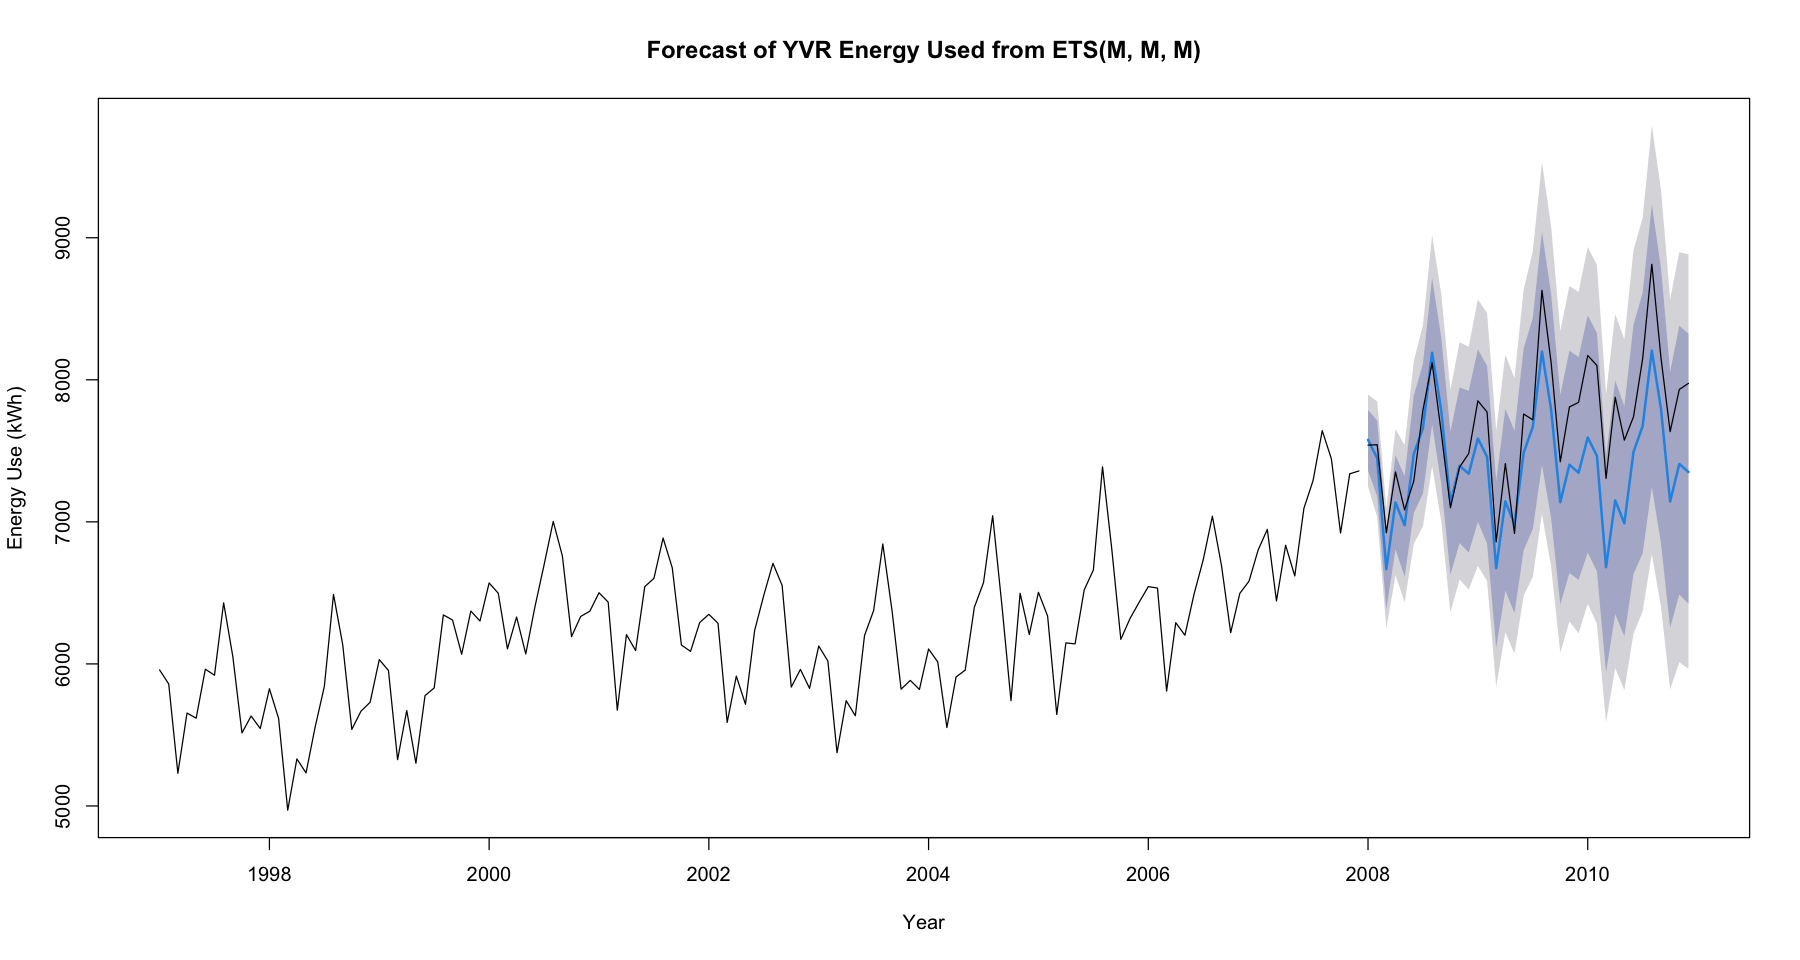

In [39]:
plot(forecast(ets.mmdm, 36), main = 'Forecast of YVR Energy Used from ETS(M, M, M)',
                ylab = "Energy Use (kWh)", xlab = "Year")
lines(energy.ts.test)

AAA

The ETS(A,A,A) model has an average residuals lower than 1, indicating that the forecasts are biased. 

[1] -1.171192


	Ljung-Box test

data:  Residuals from ETS(A,A,A)
Q* = 14.031, df = 8, p-value = 0.08095

Model df: 16.   Total lags used: 24



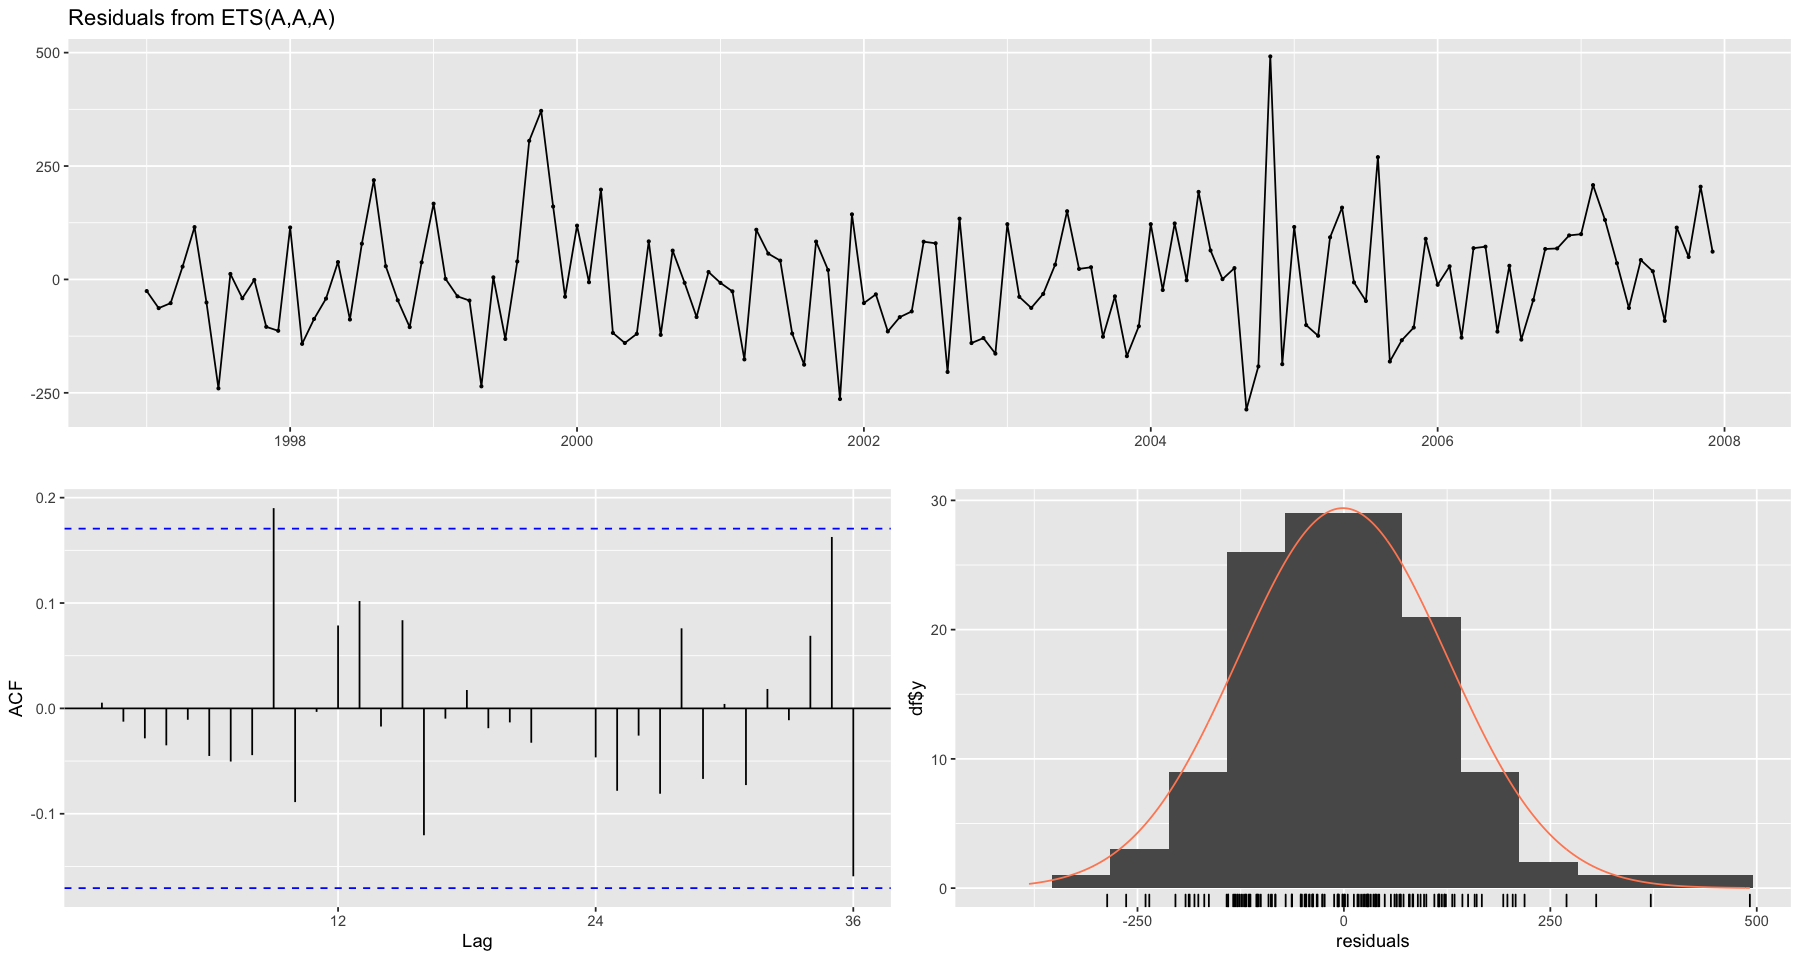

In [40]:
ets.aaa = ets(energy.ts.train, model = 'AAA')
mean(residuals(ets.aaa))
checkresiduals(ets.aaa)

In [41]:
plot(forecast(ets.aaa, 36), main = 'Forecast of YVR Energy Used from ETS(A, A, A)',
                ylab = "Energy Use (kWh)", xlab = "Year")
lines(energy.ts.test)

ANA

The ETS model generated by R is having an average residual greater than 0, indicating that the forecasts are biased.

[1] 12.73609


	Ljung-Box test

data:  Residuals from ETS(A,N,A)
Q* = 14.089, df = 10, p-value = 0.169

Model df: 14.   Total lags used: 24



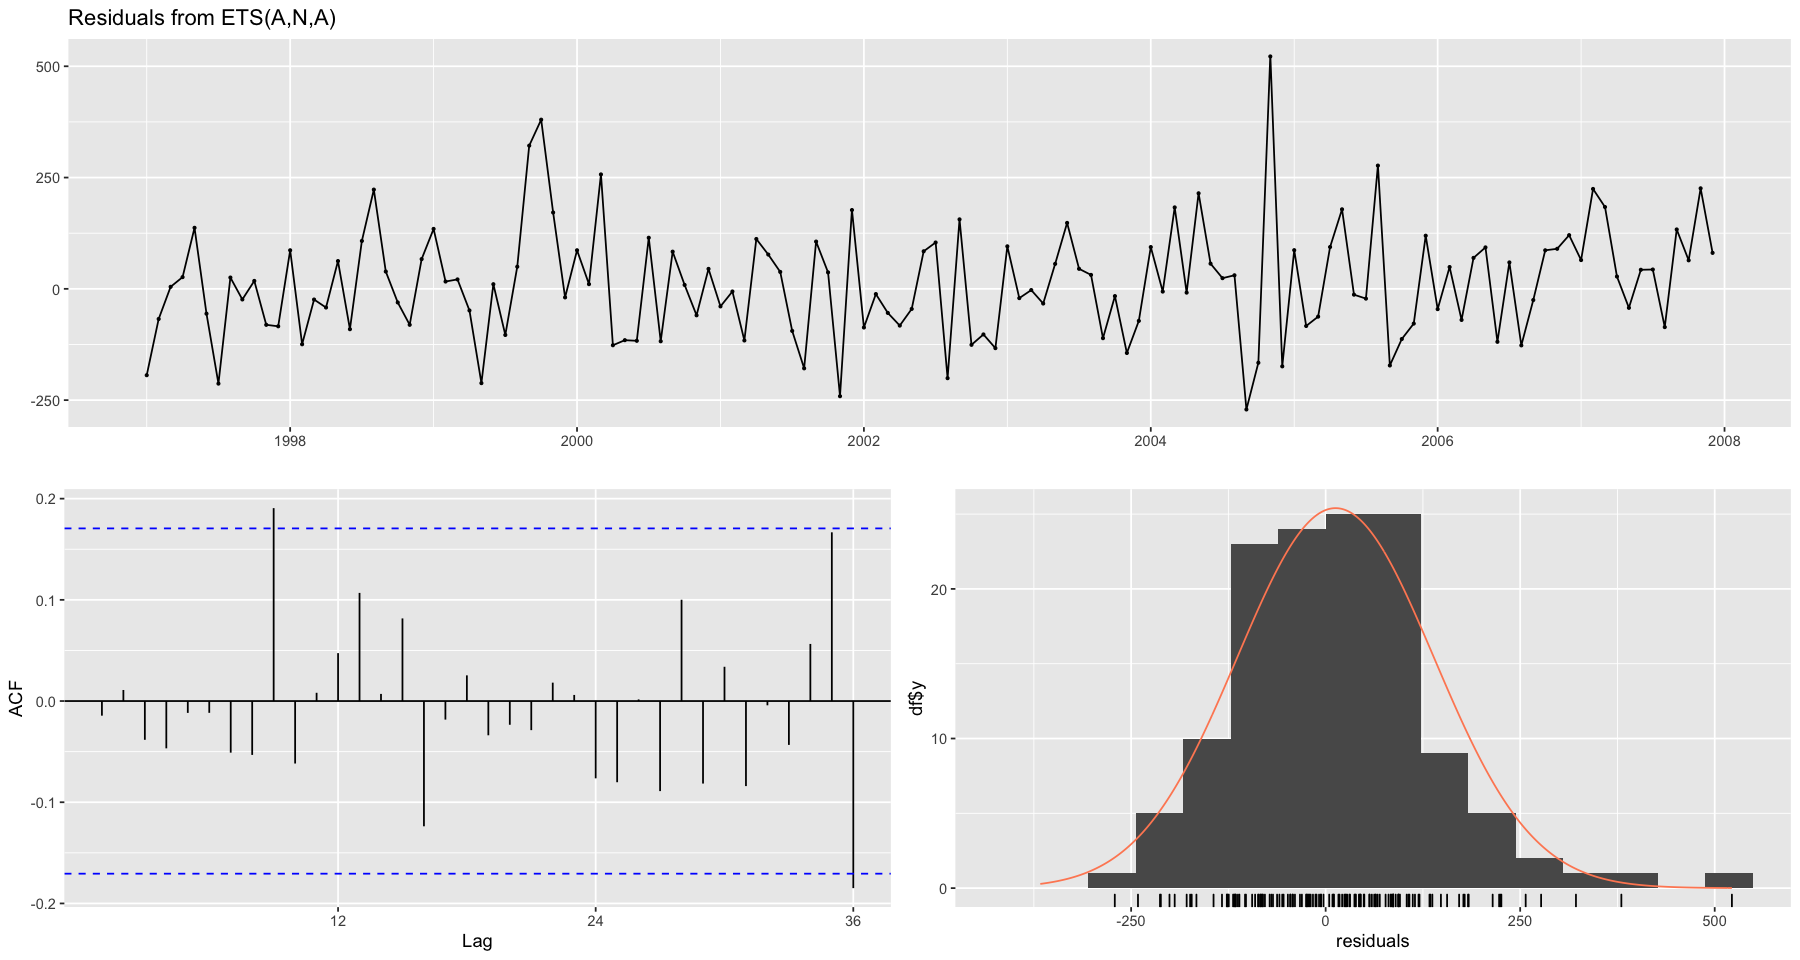

In [42]:
ets.auto = ets(energy.ts.train)
mean(residuals(ets.auto))
checkresiduals(ets.auto)

In [43]:
plot(forecast(ets.auto, 36), main = 'Forecast of YVR Energy Used from ETS(A, N, A)',
                ylab = "Energy Use (kWh)", xlab = "Year")
lines(energy.ts.test)

Accuracy measurement

In [44]:
method.ets <- c('MAA', 'MMM','MMdM', 'AAA', 'ANA')
cbind(method.ets, round(rbind(
      accuracy(forecast(ets.maa), energy.ts.test)[2,c(2,3,5,6)],
      accuracy(forecast(ets.mmm), energy.ts.test)[2,c(2,3,5,6)],
      accuracy(forecast(ets.mmdm), energy.ts.test)[2,c(2,3,5,6)],
      accuracy(forecast(ets.aaa), energy.ts.test)[2,c(2,3,5,6)],
      accuracy(forecast(ets.auto), energy.ts.test)[2,c(2,3,5,6)]
      ),3))

method.ets RMSE    MAE     MAPE  MASE 
[1,] MAA        159.108 126.276 1.695 0.477
[2,] MMM        239.656 200.124 2.614 0.755
[3,] MMdM       239.656 200.124 2.614 0.755
[4,] AAA        158.428 130.92  1.725 0.494
[5,] ANA        249.836 196.232 2.533 0.741

According to the accuracy measure above and the visual assessment from the forecast on the test data, `ETS(M,A,A)` generates the most accurate forcast among all the ETS model.

---

<div class="alert alert-block alert-danger">
<a id="AppendixB"></a>

# Appendix B:
# ARIMA Models 
</div>

#### Appendix B Step 1 Plotting data

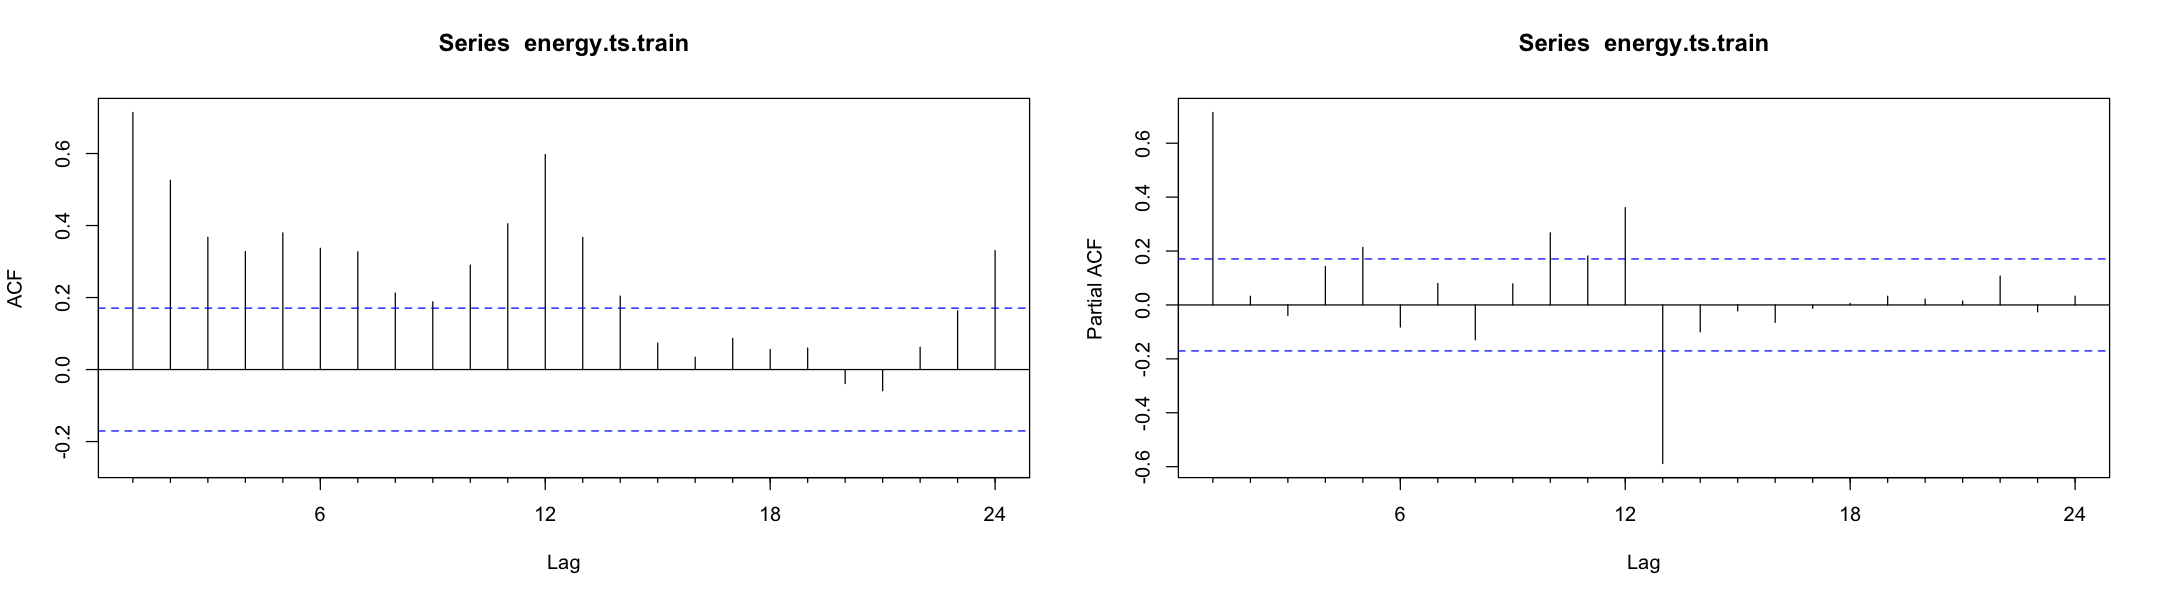

In [45]:
#plot the acf and pacf on training set
options(repr.plot.width=18, repr.plot.height=5)
par(mfrow=c(1,2))

Acf(energy.ts.train)
Pacf(energy.ts.train)

#### Appendix B Step 2 Differencing

In [46]:
#seasonal differencing
options(repr.plot.width=18, repr.plot.height=5)
par(mfrow=c(1,3))

plot(diff(energy.ts.train,12))
Acf(diff(energy.ts.train,12))
Pacf(diff(energy.ts.train,12))

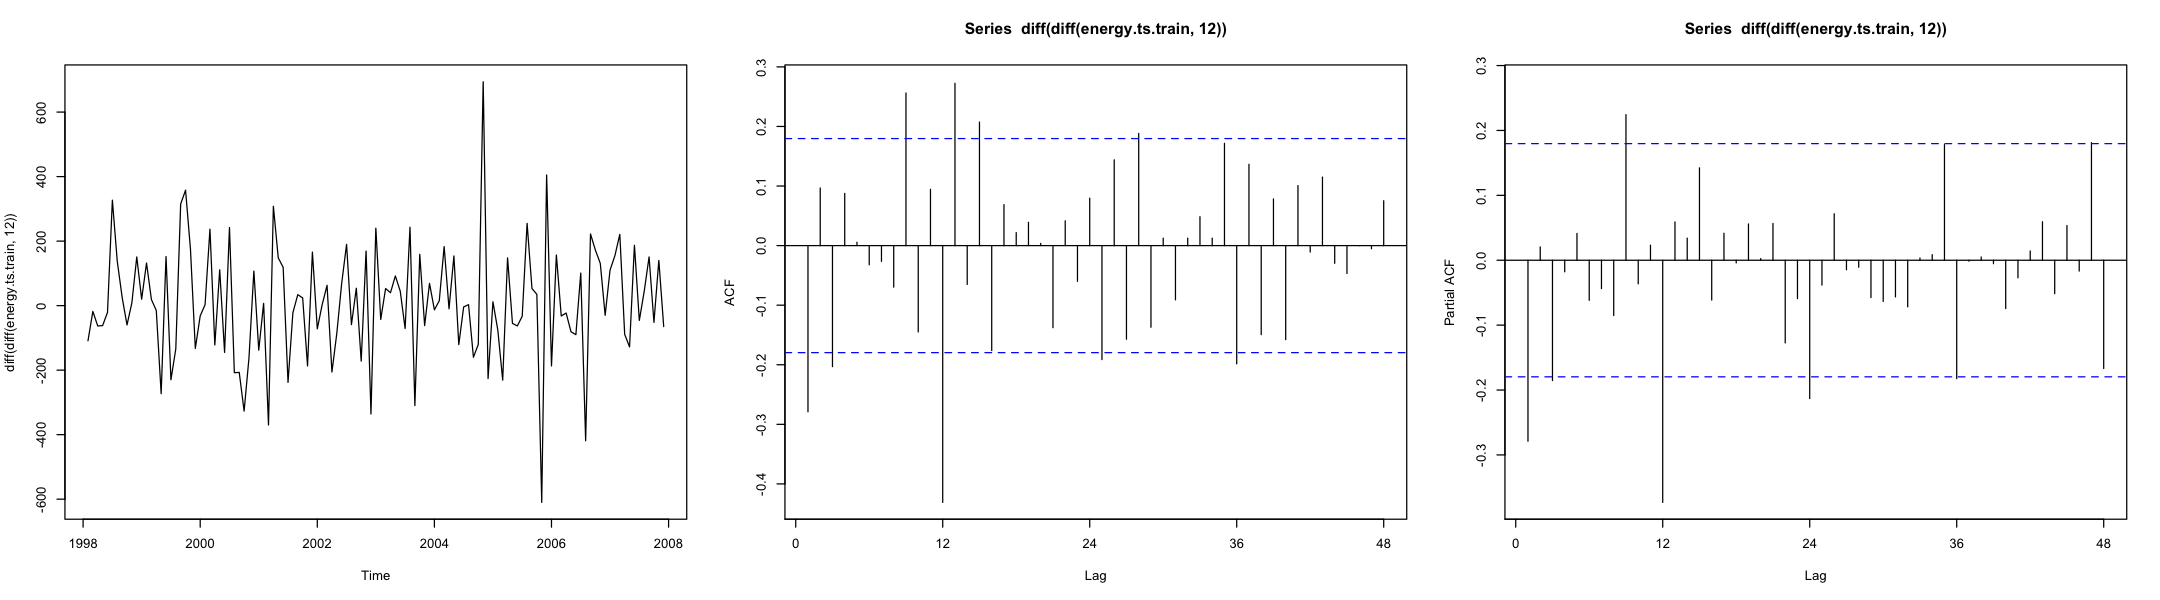

In [47]:
#first order differencing on top of seasonal
options(repr.plot.width=18, repr.plot.height=5)
par(mfrow=c(1,3))

plot(diff(diff(energy.ts.train,12)))
Acf(diff(diff(energy.ts.train,12)),48)
Pacf(diff(diff(energy.ts.train,12)),48)

The data is stationary after seasonal and first order differencing. Therefore, it can be fit to an Arima model.

#### Appendix B Step 3 Choose and fit model

In [48]:
#fit the model1 with (110) (210)
fit.energy.1 <- Arima(energy.ts.train, order=c(1, 1, 0), seasonal=c(2, 1, 0), include.constant=TRUE)
summary(fit.energy.1)

Series: energy.ts.train 
ARIMA(1,1,0)(2,1,0)[12] 

Coefficients:
          ar1     sar1     sar2
      -0.2482  -0.4993  -0.2136
s.e.   0.0909   0.0937   0.1006

sigma^2 = 24330:  log likelihood = -769.95
AIC=1547.9   AICc=1548.25   BIC=1559.01

Training set error measures:
                   ME     RMSE      MAE       MPE     MAPE      MASE
Training set 9.902709 146.2229 104.9458 0.1326502 1.668495 0.3960468
                    ACF1
Training set -0.00807819

In [49]:
#use auto arima to generate second model
fit.energy.2 <- auto.arima(energy.ts.train, stepwise=FALSE, approximation=FALSE) 
summary(fit.energy.2)

Series: energy.ts.train 
ARIMA(1,1,0)(2,1,0)[12] 

Coefficients:
          ar1     sar1     sar2
      -0.2482  -0.4993  -0.2136
s.e.   0.0909   0.0937   0.1006

sigma^2 = 24330:  log likelihood = -769.95
AIC=1547.9   AICc=1548.25   BIC=1559.01

Training set error measures:
                   ME     RMSE      MAE       MPE     MAPE      MASE
Training set 9.902709 146.2229 104.9458 0.1326502 1.668495 0.3960468
                    ACF1
Training set -0.00807819

In [50]:
#fit the model3 with (110) (211)
fit.energy.3 <- Arima(energy.ts.train, order=c(1, 1, 0), seasonal=c(2, 1, 1)) 
summary(fit.energy.3)

Series: energy.ts.train 
ARIMA(1,1,0)(2,1,1)[12] 

Coefficients:
          ar1    sar1    sar2     sma1
      -0.2126  0.1602  0.0107  -1.0000
s.e.   0.0903  0.1008  0.0991   0.1544

sigma^2 = 17696:  log likelihood = -761.29
AIC=1532.58   AICc=1533.11   BIC=1546.47

Training set error measures:
                   ME     RMSE      MAE       MPE    MAPE      MASE
Training set 9.581445 124.1642 90.22309 0.1278401 1.43656 0.3404859
                     ACF1
Training set -0.007696523

In [51]:
#fit.energy.3 <- auto.arima(energy.ts.train, stepwise=FALSE, approximation=FALSE, trace=TRUE, ic="aicc")

#### Appendix B Step 4 Check residuals

[1] 9.902709


	Ljung-Box test

data:  Residuals from ARIMA(1,1,0)(2,1,0)[12]
Q* = 22.208, df = 21, p-value = 0.3876

Model df: 3.   Total lags used: 24



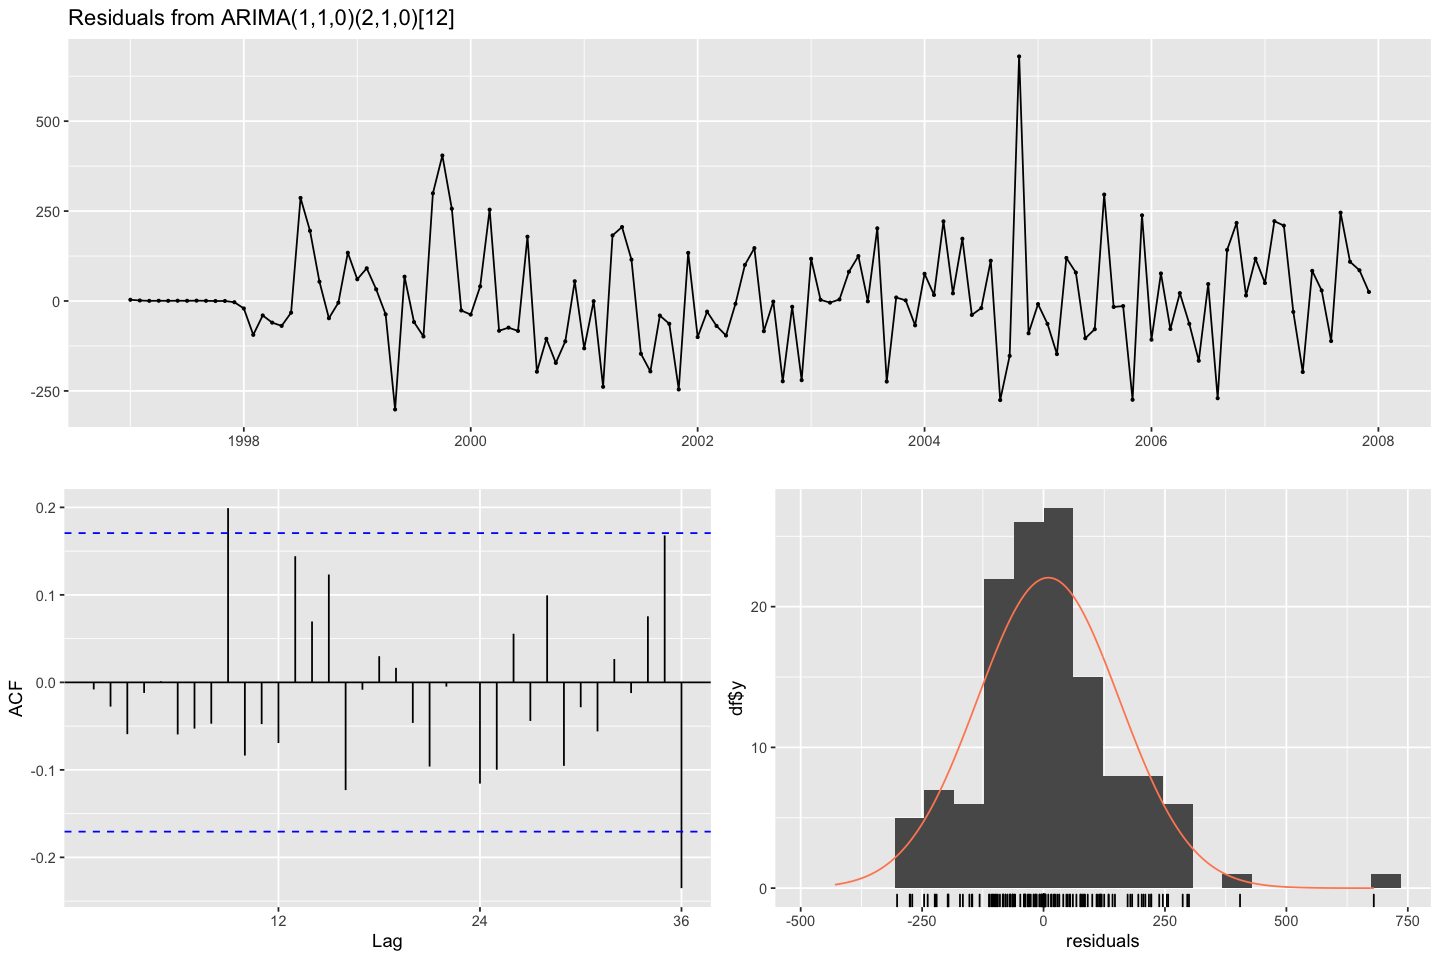

In [52]:
#check mean and residuals for model1
mean(residuals(fit.energy.1))

options(repr.plot.width=12, repr.plot.height=8)
checkresiduals(fit.energy.1)

[1] 9.581445


	Ljung-Box test

data:  Residuals from ARIMA(1,1,0)(2,1,1)[12]
Q* = 18.452, df = 20, p-value = 0.5577

Model df: 4.   Total lags used: 24



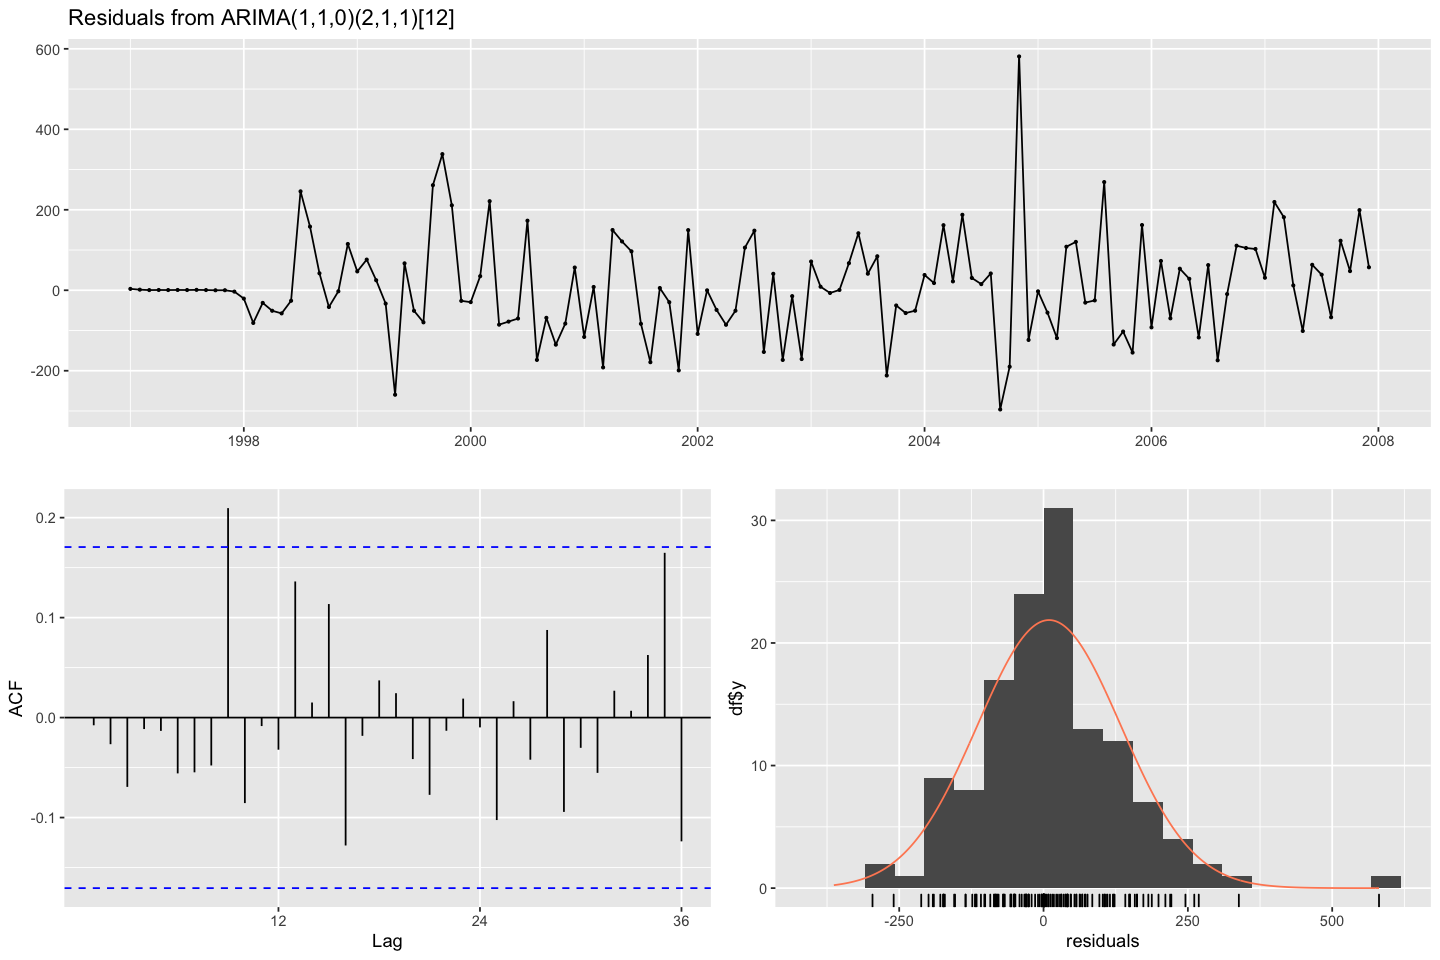

In [53]:
#check mean and residuals for model3
mean(residuals(fit.energy.3))

options(repr.plot.width=12, repr.plot.height=8)
checkresiduals(fit.energy.3)

#### Appendix B Step 5 Compare accuracy measures

In [54]:
#check accuracy for model 1
accuracy(forecast(fit.energy.1, h=36), energy.ts.test)

ME          RMSE     MAE      MPE        MAPE     MASE     
Training set    9.902709 146.2229 104.9458  0.1326502 1.668495 0.3960468
Test set     -459.577320 532.0309 459.5773 -5.9855995 5.985600 1.7343631
             ACF1        Theil's U
Training set -0.00807819       NA 
Test set      0.62538264 1.101258

In [55]:
#check accuracy for model 3
accuracy(forecast(fit.energy.3, h=36), energy.ts.test)

ME         RMSE     MAE       MPE        MAPE     MASE     
Training set   9.581445 124.1642  90.22309  0.1278401 1.436560 0.3404859
Test set     -69.184199 172.8331 125.74320 -0.9815744 1.665513 0.4745325
             ACF1         Theil's U
Training set -0.007696523        NA
Test set      0.200144938 0.3670455

The accuracy measures on test set for model 3 are lower than those of model 1. Therefore, model 3 is preferred.

#### Appendix B Step 6 Calculate forecasts

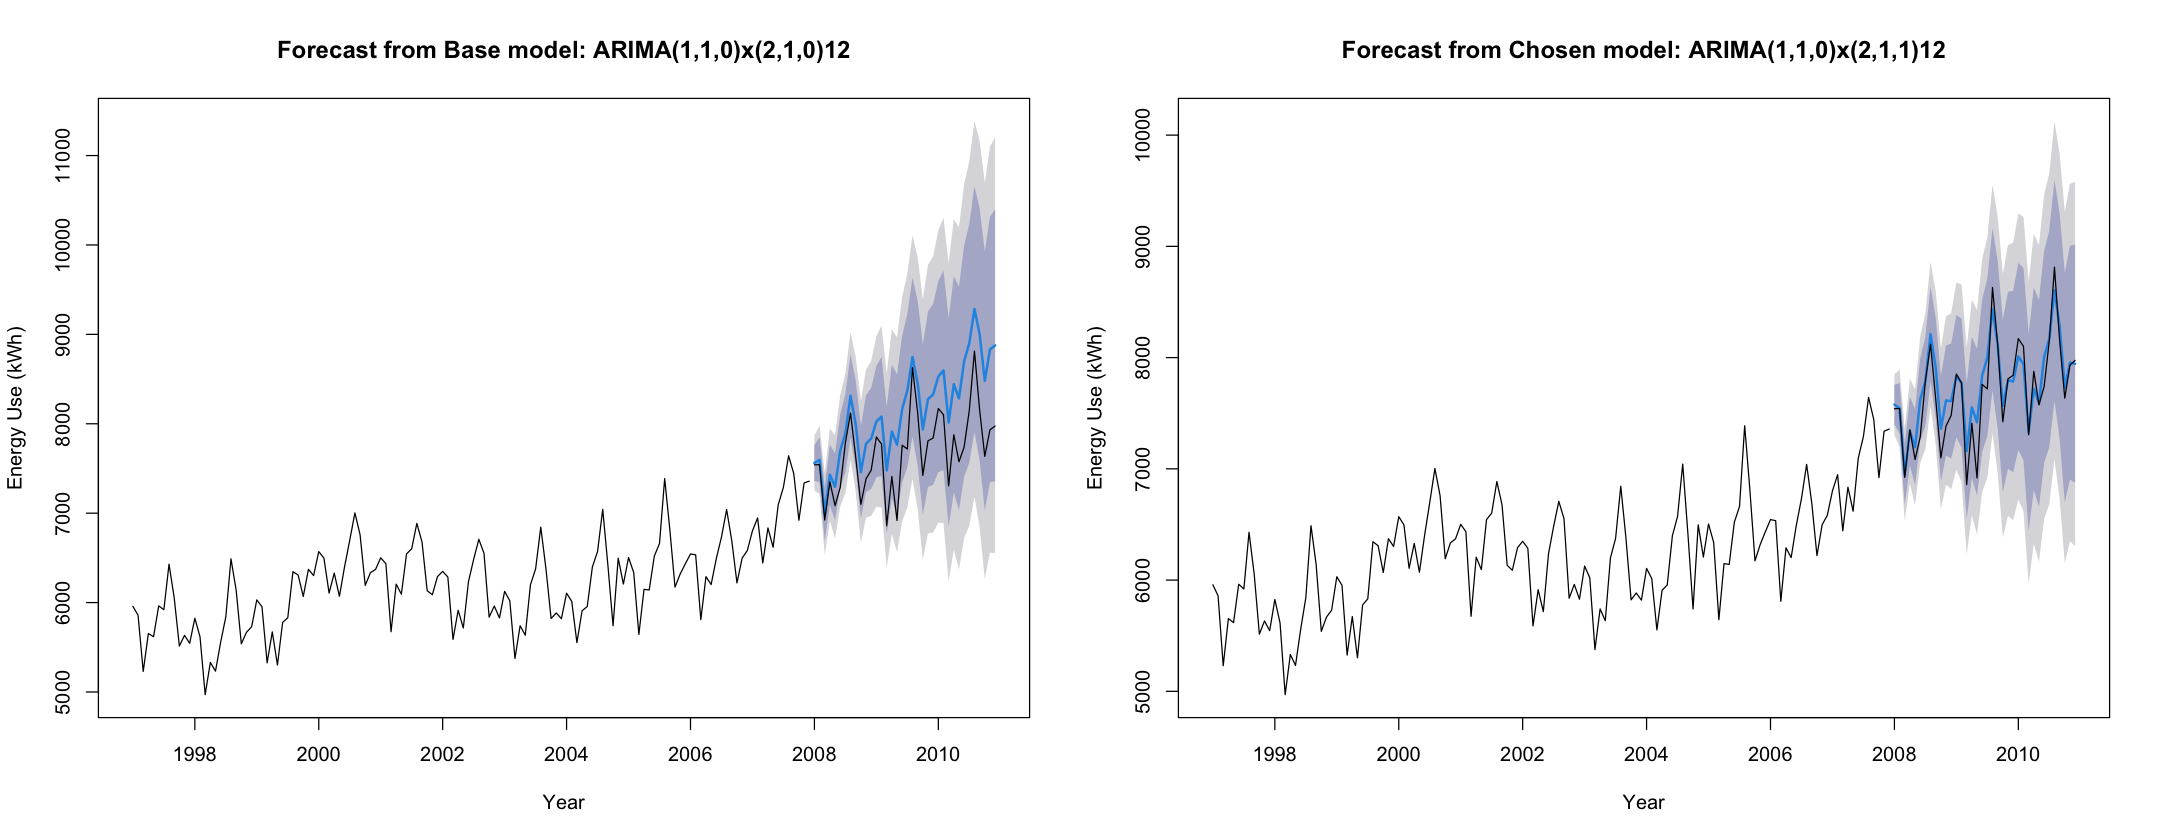

In [56]:
# plot the forecast of 2 ARIMA model with confidence interval 
options(repr.plot.width=18, repr.plot.height=7)
par(mfrow=c(1,2))
plot(forecast(fit.energy.1, 36), main = 'Forecast from Base model: ARIMA(1,1,0)x(2,1,0)12',
                ylab = "Energy Use (kWh)", xlab = "Year")
lines(energy.ts.test)

plot(forecast(fit.energy.3, 36), main = 'Forecast from Chosen model: ARIMA(1,1,0)x(2,1,1)12',
                ylab = "Energy Use (kWh)", xlab = "Year")
lines(energy.ts.test)


In [57]:
# generate forecasts for model 1 and 3 and add back residuals
fit.energy.1.forecasts <- forecast(fit.energy.1, h=36)$mean + 9.9
fit.energy.3.forecasts <- forecast(fit.energy.3, h=36)$mean + 9.58

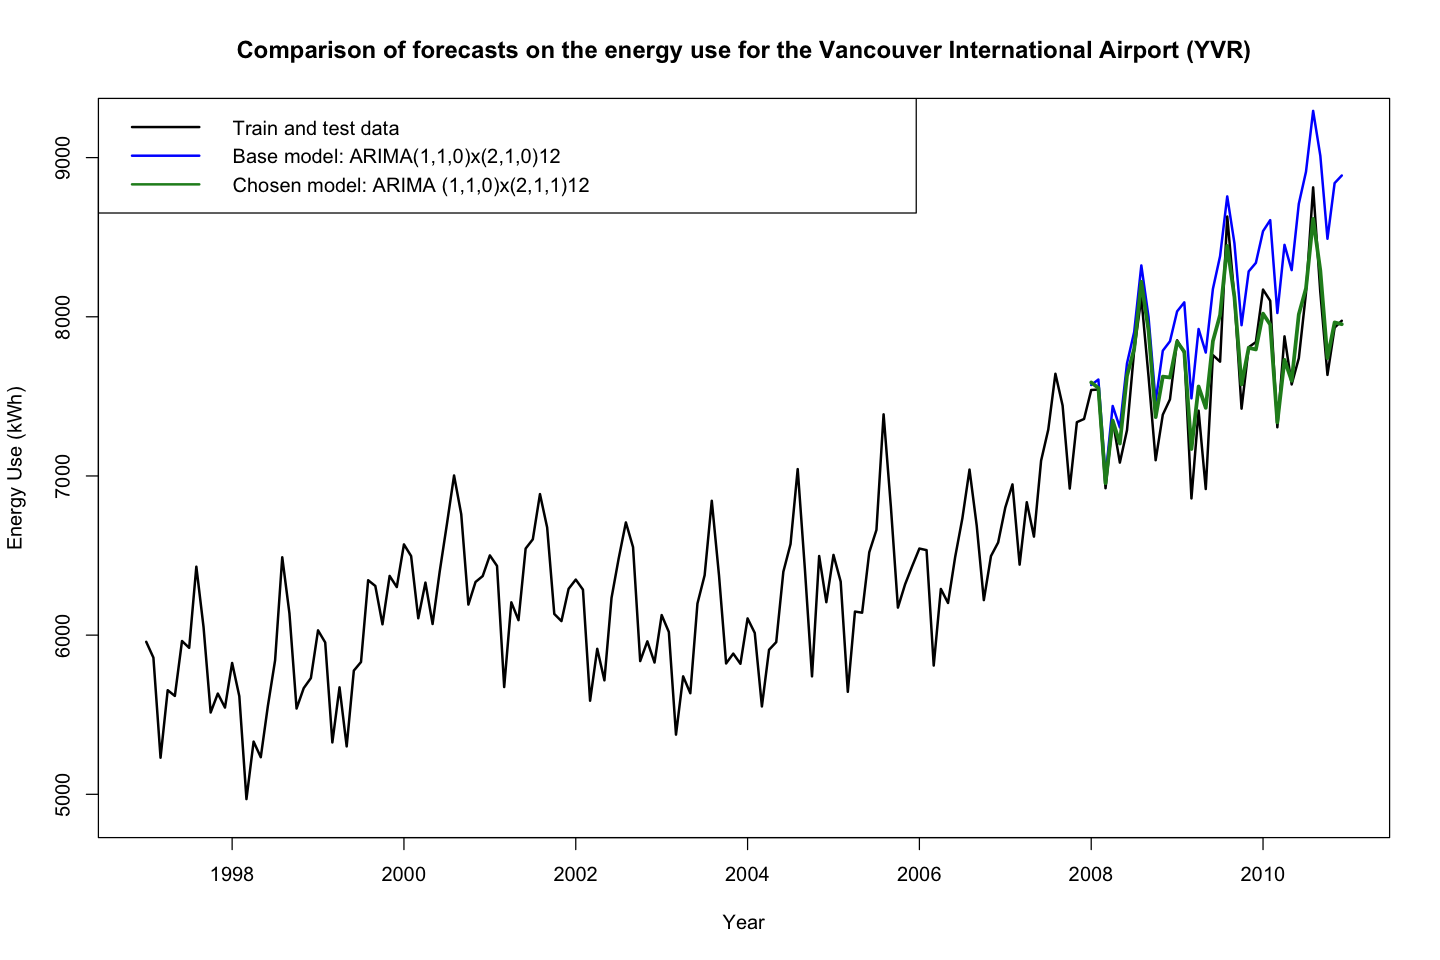

In [58]:
# plot the forecast of 2 ARIMA model with residuals added
options(repr.plot.width=12, repr.plot.height=8)
plot(energy.ts, ylim = c(4900,9200),lwd=2, ylab="Energy Use (kWh)", xlab="Year", main="Comparison of forecasts on the energy use for the Vancouver International Airport (YVR)")
lines(fit.energy.1.forecasts, col="blue", lwd=2)
lines(fit.energy.3.forecasts, col="forestgreen", lwd=3)
legend("topleft",lty=1,lwd=2, col=c("black","blue", 'forestgreen'), c("Train and test data","Base model: ARIMA(1,1,0)x(2,1,0)12","Chosen model: ARIMA (1,1,0)x(2,1,1)12"))

According to the accuracy measure above and the visual assessment from the forecast on the test data, `ARIMA (1,1,0)x(2,1,1)12` generates the most accurate forcast among all the ARIMA model.